Load packages

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use("seaborn")
%matplotlib inline
#%matplotlib notebook
import datetime as dt

In [2]:
blue = '#0072B2'
bluegreen = '#009E73'
yellow = '#F0E442'
skyblue = '#56B4E9'
orange = '#E69F00'
vermilion = '#D55E00'

# Data input

## Eurostat shapefiles

In [3]:
gdf_nuts3 = gpd.read_file(
    'data/NUTS_RG_01M_2021_3857_LEVL_3.shp.zip',
    crs = "EPSG:4326"
)

In [4]:
# Filter out all countries except Norway
gdf_NOnuts3 = gdf_nuts3[gdf_nuts3.CNTR_CODE.str.contains('NO')]
# We manually filter out Svalbard and Jan Mayen as we are not interested in them
gdf_NOnuts3 = gdf_NOnuts3.query('FID != "NO0B1" and FID != "NO0B2"')
# Return to sequential index from 0 to 13
gdf_NOnuts3 = gdf_NOnuts3.reset_index()
# Set the coordinate reference system to EPSG:4326 - same as our twitter data. 
gdf_NOnuts3 = gdf_NOnuts3.to_crs("EPSG:4326")

## Twitter data

In [5]:
df_twitter = pd.read_csv(
    "data/fourth_rendition_geolocated_id_posneutral_predict.csv",
    parse_dates=[
        'created_at'
    ]
)

We group the results at a monthly resolution 

In [6]:
df_twitter_monthly = pd.DataFrame(df_twitter.copy())
df_twitter_monthly.index = df_twitter_monthly[
    'created_at'
].dt.to_period(
    'M'
)

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


Assign the sentiment values

Count gives us the total number of instance, while sum gives us the number of 1-values (i.e. non-negative tweets)

In [7]:
df_monthly_results = pd.DataFrame(df_twitter_monthly.copy())
df_monthly_results = df_monthly_results.drop(
    columns={
        'username',
        'Unnamed: 0',
        'text',
        'like_count',
        'quote_count',
        'logits0',
        'logits1',
    }
)

In [8]:
# Transform the twitter data it into a GeoDataFrame with point geometry based on longitude and latitude.
gdf_monthly_results = gpd.GeoDataFrame(
    df_monthly_results,
    crs = "EPSG:4326",
    geometry=gpd.points_from_xy(
        df_twitter.longitude, 
        df_twitter.latitude
    )
).drop(
    columns={
        'latitude',
        'longitude'
    }
)
gdf_monthly_results

id        loc                created_at  label  \
created_at                                                                    
2008-12              1060689807   Nordmøre 2008-12-16 14:43:57+00:00    1.0   
2008-12              1045067708    Lofoten 2008-12-08 14:12:10+00:00    0.0   
2008-12              1044682060       Oslo 2008-12-08 07:25:53+00:00    1.0   
2008-11              1022214006     Bergen 2008-11-25 05:33:07+00:00    0.0   
2008-11              1010970723     Bergen 2008-11-18 09:33:01+00:00    1.0   
...                         ...        ...                       ...    ...   
2022-10     1581877020010901505       Oslo 2022-10-17 05:17:26+00:00    1.0   
2022-10     1581874121306095616  Trondheim 2022-10-17 05:05:54+00:00    0.0   
2022-10     1581870849753174016   Grimstad 2022-10-17 04:52:54+00:00    1.0   
2022-10     1581853564976402432     Bergen 2022-10-17 03:44:13+00:00    1.0   
2022-10     1581799155575316480   Oppegård 2022-10-17 00:08:01+00:00    NaN   

                             geometry  
created_at                             
2008-12      POINT (8.97846 63.02174)  
2008-12     POINT (14.66639 68.33306)  
2008-12     POINT (10.73897 59.91333)  
2008-11      POINT (5.32592 60.39431)  
2008-11      POINT (5.32592 60.39431)  
...                               ...  
2022-10     POINT (10.73897 59.91333)  
2022-10     POINT (10.39519 63.43057)  
2022-10      POINT (8.71283 58.28400)  
2022-10      POINT (5.32592 60.39431)  
2022-10     POINT (10.81286 59.76698)  

[68828 rows x 5 columns]

In [9]:
# Spatial joins https://geopandas.org/docs/user_guide/mergingdata.html#spatial-joins
# Basically, we add an attribute for each city related to the county the coordinate is located inside.
gdf_monthly_county_results = gdf_monthly_results.sjoin(
    gdf_NOnuts3, 
    how = "inner", 
    predicate = 'intersects'
).set_index(
    'NUTS_NAME'
).drop(
    columns={
        'index_right',
        'NUTS_ID',
        'LEVL_CODE',
        'CNTR_CODE',
        'NAME_LATN',
        'index',
        'MOUNT_TYPE',
        'URBN_TYPE',
        'COAST_TYPE',
        'FID',
        'loc'
    }
).reset_index(
)

gdf_monthly_county_results
# Summate the different cities within each county
#gdf_frequency_county = gdf_twitter_with_county.groupby(
#    'NUTS_NAME'
#).sum()
#gdf_frequency_county.head(5)

NUTS_NAME                   id                created_at  label  \
0      Møre og Romsdal           1060689807 2008-12-16 14:43:57+00:00    1.0   
1      Møre og Romsdal            991702034 2008-11-05 14:23:09+00:00    1.0   
2      Møre og Romsdal            878071117 2008-08-05 08:56:27+00:00    1.0   
3      Møre og Romsdal            817334892 2008-05-22 11:36:20+00:00    1.0   
4      Møre og Romsdal           3799885054 2009-09-06 15:39:43+00:00    1.0   
...                ...                  ...                       ...    ...   
63800            Viken  1582315632577896449 2022-10-18 10:20:19+00:00    0.0   
63801            Viken  1582308145551925250 2022-10-18 09:50:34+00:00    1.0   
63802            Viken  1582133975992086529 2022-10-17 22:18:29+00:00    1.0   
63803            Viken  1582091278925242370 2022-10-17 19:28:49+00:00    1.0   
63804            Viken  1581799155575316480 2022-10-17 00:08:01+00:00    NaN   

                        geometry  
0       POINT (8.97846 63.02174)  
1       POINT (8.97846 63.02174)  
2       POINT (8.97846 63.02174)  
3       POINT (8.97846 63.02174)  
4       POINT (8.65267 62.64703)  
...                          ...  
63800  POINT (10.17564 59.69649)  
63801  POINT (10.17564 59.69649)  
63802  POINT (11.04515 59.95341)  
63803  POINT (10.17564 59.69649)  
63804  POINT (10.81286 59.76698)  

[63805 rows x 5 columns]

### County level

In [10]:
county_list = [
    'Agder',
    'Troms og Finnmark',
    'Nordland',
    'Møre og Romsdal',
    'Vestland',
    'Rogaland',
    'Vestfold og Telemark',
    'Viken',
    'Innlandet',
    'Oslo',
    'Trøndelag'
]

In [11]:
for county in county_list:
    gdf = gdf_monthly_county_results.loc[gdf_monthly_county_results['NUTS_NAME'] == str(county)]
    print(county + ': ' + str(gdf.label.count()))

Agder: 770
Troms og Finnmark: 1122
Nordland: 915
Møre og Romsdal: 873
Vestland: 8354
Rogaland: 4280
Vestfold og Telemark: 1257
Viken: 4023
Innlandet: 2591
Oslo: 32901
Trøndelag: 6718


**Wind power data**

In [12]:
df_wp = pd.read_csv(
    'data/norway_wp_nve_250522.tsv', sep = "\t",
    parse_dates = ['Produksjon oppstart']
)

In [13]:
df_wp.loc[df_wp['Fylke'] == 'Innlandet']

Kraftverknavn      Fylke            Kommune Produksjon oppstart  \
4           Odal  Innlandet          Nord-Odal          2021-01-01   
15    Kjølberget  Innlandet  Våler (Innlandet)          2020-01-01   
33     Raskiftet  Innlandet               Åmot          2018-01-01   

    Installert effekt [MW]  Middelproduksjon [GWh]  Antall turbiner  \
4                     50.0                  155.80             10.0   
15                    55.9                  194.79             13.0   
33                   111.6                  368.50             31.0   

    Prisområde                                 NVEs kraftverkside  \
4          1.0  https://www.nve.no/energi/energisystem/vindkra...   
15         1.0  https://www.nve.no/energi/energisystem/vindkra...   
33         1.0  https://www.nve.no/energi/energisystem/vindkra...   

                                        Til konsesjon  
4   https://www.nve.no/konsesjon/konsesjonssaker/k...  
15  https://www.nve.no/konsesjon/konsesjonssaker/k...  
33  https://www.nve.no/konsesjon/konsesjonssaker/k...

In [14]:
df_wp = pd.read_csv(
    'data/vindkraft_utbygd.csv', 
    sep = ","
).assign(
    in_operation = lambda x : pd.to_datetime(x.forsteIdriftDato,unit='ms')
)

df_wp = df_wp[['effekt_MW_idrift','forventetProduksjon_Gwh','fylkeNavn','in_operation']]

In [15]:
df_wp = pd.read_csv(
    'data/norway_wp_nve_250522.tsv', sep = "\t",
    parse_dates = ['Produksjon oppstart']
)

df_wp_Rogaland = df_wp.loc[df_wp['Fylke'] == 'Innlandet'].groupby(
    'Produksjon oppstart',
    as_index = False
).sum(
).rename(
    columns=
    {
        'Middelproduksjon [GWh]': 'average_generation_GWh',
        'Installert effekt [MW]': 'installed_capacity_MW'
    }
).assign(
    cumulative_annually_average_production_GWh = lambda x: x.average_generation_GWh.cumsum(),
    cumulative_installed_capacity_MW = lambda x: x.installed_capacity_MW.cumsum()
)

<AxesSubplot:xlabel='Produksjon oppstart'>

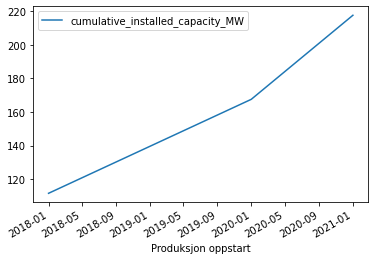

In [16]:
df_wp_Rogaland.set_index('Produksjon oppstart').plot(
    y = 'cumulative_installed_capacity_MW'
)

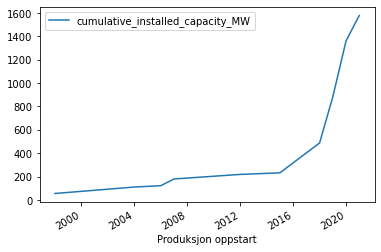

In [17]:
df_wp_county = df_wp.loc[df_wp['Fylke'] == str(county)].groupby(
    'Produksjon oppstart',
        as_index = False
    ).sum(
    ).rename(
        columns=
        {
            'Middelproduksjon [GWh]': 'average_generation_GWh',
            'Installert effekt [MW]': 'installed_capacity_MW'
        }
    ).assign(
        cumulative_annually_average_production_GWh = lambda x: x.average_generation_GWh.cumsum(),
        cumulative_installed_capacity_MW = lambda x: x.installed_capacity_MW.cumsum()
    ).set_index('Produksjon oppstart').plot(
        #ax = ax1.twinx(),
        y = 'cumulative_installed_capacity_MW'
    )

In [18]:
row_nr = 0
column_nr = 0
fig = plt.figure(figsize=(5*3.54,4*3.54), dpi=600,layout="constrained")

gs = fig.add_gridspec(4,3, wspace = 0.1, hspace = 0.1)

for county in county_list:
    ax1 = fig.add_subplot(gs[row_nr,column_nr])
    gdf = gdf_monthly_county_results.loc[gdf_monthly_county_results['NUTS_NAME'] == str(county)]
    gdf.reset_index(
    ).assign(
        year_month = lambda x: x.created_at.dt.to_period('M')
    ).sort_values(
        'year_month'
    ).set_index(
        'year_month'
    ).assign(
        total_tweets = lambda x: x.groupby(level=0).count().label,
        non_negative_tweets = lambda x: x.groupby(level=0).sum().label,
        negative_tweets = lambda x: x.total_tweets - x.non_negative_tweets,
        share_negative = lambda x: x.negative_tweets/x.total_tweets
    ).drop(
        columns={
            'geometry',
            'index',
            'label',
            'created_at'
        }
    ).plot.area(
        title = county,
        y = ['non_negative_tweets','negative_tweets'],
        ax=ax1,
        color = [blue,vermilion]
    )
    
    column_nr += 1
    if column_nr == 3:
        column_nr = 0
        row_nr += 1
    plt.xlabel('Year')
    plt.ylabel('Amount of tweets')
    #plt.savefig('figures/all_counties_temporal.pdf')


/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation

In [19]:
gdf_monthly_county_results

NUTS_NAME                   id                created_at  label  \
0      Møre og Romsdal           1060689807 2008-12-16 14:43:57+00:00    1.0   
1      Møre og Romsdal            991702034 2008-11-05 14:23:09+00:00    1.0   
2      Møre og Romsdal            878071117 2008-08-05 08:56:27+00:00    1.0   
3      Møre og Romsdal            817334892 2008-05-22 11:36:20+00:00    1.0   
4      Møre og Romsdal           3799885054 2009-09-06 15:39:43+00:00    1.0   
...                ...                  ...                       ...    ...   
63800            Viken  1582315632577896449 2022-10-18 10:20:19+00:00    0.0   
63801            Viken  1582308145551925250 2022-10-18 09:50:34+00:00    1.0   
63802            Viken  1582133975992086529 2022-10-17 22:18:29+00:00    1.0   
63803            Viken  1582091278925242370 2022-10-17 19:28:49+00:00    1.0   
63804            Viken  1581799155575316480 2022-10-17 00:08:01+00:00    NaN   

                        geometry  
0       POINT (8.97846 63.02174)  
1       POINT (8.97846 63.02174)  
2       POINT (8.97846 63.02174)  
3       POINT (8.97846 63.02174)  
4       POINT (8.65267 62.64703)  
...                          ...  
63800  POINT (10.17564 59.69649)  
63801  POINT (10.17564 59.69649)  
63802  POINT (11.04515 59.95341)  
63803  POINT (10.17564 59.69649)  
63804  POINT (10.81286 59.76698)  

[63805 rows x 5 columns]

In [20]:
df_wp.loc[df_wp['Fylke'] == str('Møre og Romsdal')]

Kraftverknavn            Fylke  Kommune Produksjon oppstart  \
2          Haram  Møre og Romsdal  Ålesund          2021-01-01   
60         Smøla  Møre og Romsdal    Smøla          2002-01-01   
62        Sandøy  Møre og Romsdal  Ålesund          1999-01-01   

    Installert effekt [MW]  Middelproduksjon [GWh]  Antall turbiner  \
2                    33.60                  127.18              8.0   
60                  150.40                  356.00             68.0   
62                    3.75                   10.00              5.0   

    Prisområde                                 NVEs kraftverkside  \
2          3.0  https://www.nve.no/energi/energisystem/vindkra...   
60         3.0  https://www.nve.no/energi/energisystem/vindkra...   
62         3.0  https://www.nve.no/energi/energisystem/vindkra...   

                                        Til konsesjon  
2   https://www.nve.no/konsesjon/konsesjonssaker/k...  
60  https://www.nve.no/konsesjon/konsesjonssaker/k...  
62  https://www.nve.no/konsesjon/konsesjonssaker/k...

In [21]:
min(df_wp.loc[df_wp['Fylke'] == str(county)].rename(columns={
    'Produksjon oppstart' : 'year_month',
}
                                               ).year_month)

Timestamp('1998-01-01 00:00:00')

In [22]:
gdf = gdf_monthly_county_results.loc[gdf_monthly_county_results['NUTS_NAME'] == str(county)]

In [23]:
pd.read_csv(
    'data/vindkraft_utbygd.csv', 
    sep = ";"
).assign(
    in_operation = lambda x : pd.to_datetime(x.forsteIdriftDato,unit='ms')
).groupby(
    'in_operation',
    as_index = True
).sum(
).rename(
    columns=
    {
        'forventetProduksjon_Gwh': 'expected_generation_GWh',
        'effekt_MW': 'installed_capacity_MW'
    }
).assign(
    cumulative_annually_average_production_GWh = lambda x: x.expected_generation_GWh.cumsum(),
    cumulative_installed_capacity_MW = lambda x: x.installed_capacity_MW.cumsum()
)


AttributeError: 'DataFrame' object has no attribute 'forsteIdriftDato'

In [24]:
df_wp.loc[df_wp['fylkeNavn'] == 'Vestfold og Telemark']

KeyError: 'fylkeNavn'

In [ ]:
for county in county_list:
    fig, ax = plt.subplots(figsize=(2*3.54,3.54), dpi=300,layout="constrained")
    ax2 = ax.twinx()
    
    gdf = gdf_monthly_county_results.loc[gdf_monthly_county_results['NUTS_NAME'] == str(county)]
    gdf.reset_index(
    ).assign(
        year_month = lambda x: x.created_at.dt.to_period('M')
    ).sort_values(
        'year_month'
    ).set_index(
        'year_month'
    ).assign(
        total_tweets = lambda x: x.groupby(level=0).count().label,
        non_negative_tweets = lambda x: x.groupby(level=0).sum().label,
        negative_tweets = lambda x: x.total_tweets - x.non_negative_tweets,
        share_negative = lambda x: x.negative_tweets/x.total_tweets
    ).drop(
        columns={
            'geometry',
            'index',
            'label',
            'created_at'
        }
    ).plot.area(
        title = county,
        y = ['negative_tweets','non_negative_tweets'],
        ax=ax,
        color = [vermilion,blue],
        label = ['Negative tweets','Non-negative tweets']
    )
    
    max_tweet = gdf.assign(year_month = lambda x: x.created_at.dt.to_period('M')).groupby('year_month').count().label.max()
    
    ax.axvline(
        dt.datetime(2019, 4, 1),
        color="#E69F00",
        label='NVE present proposed NFWP',
        linestyle = "--",
        linewidth = 1,
    )
    
    ax.axvline(
        dt.datetime(2019, 9, 1),
        color="#000000",
        label='Municipal and regional election',
        linestyle = "--",
        linewidth = 1,
    )
    
    ax.axvline(
        dt.datetime(2020, 6, 1),
        color="#CC79A7",
        label='Meld. St. 28 (2019-2020) - Tighter rules for wind power',
        linestyle = "--",
        linewidth = 1,
    )
    
    ax.axvline(
        dt.datetime(2021, 9, 1),
        color="#56B4E9",
        label='Parliamentary election and Fosen Wind controversy',
        linestyle = "--",
        linewidth = 1,
    )
    
    
    ax.legend(loc='upper left', framealpha = 0)
    ax.set_xlabel('Year')
    ax.set_ylim(0,max_tweet*1.2)
    ax.set_ylabel('Number of tweets')
    ax.grid(alpha=0.5, linestyle = '--')
    
    #.groupby(
#    'in_operation',
#    as_index = True
#).sum(
#).rename(
#    columns=
#    {
#        'forventetProduksjon_Gwh': 'expected_generation_GWh',
#        'effekt_MW': 'installed_capacity_MW'
#    }
#).assign(
#    cumulative_annually_average_production_GWh = lambda x: x.expected_generation_GWh.cumsum(),
#    cumulative_installed_capacity_MW = lambda x: x.installed_capacity_MW.cumsum()
#)

    
    if df_wp.loc[df_wp['fylkeNavn'] == str(county)].count().in_operation != 0:

        df_wp.loc[df_wp['fylkeNavn'] == str(county)].groupby(
        'in_operation',
            as_index = False
        ).sum(
        ).rename(
            columns=
            {
                'forventetProduksjon_Gwh': 'expected_generation_GWh',
                'effekt_MW_idrift': 'installed_capacity_MW',
            }
        ).set_index(
            "in_operation"
        ).resample(
            "M"
        ).sum(
        ).reset_index(
        ).assign(
            cumulative_annually_average_production_GWh = lambda x: x.expected_generation_GWh.cumsum(),
            cumulative_installed_capacity_MW = lambda x: x.installed_capacity_MW.cumsum()
        ).set_index('in_operation').plot(
            ax = ax2,
            y = 'cumulative_installed_capacity_MW',
            color = bluegreen
        )
        
        max_capacity = df_wp.loc[df_wp['fylkeNavn'] == str(county)].groupby(
        'in_operation',
            as_index = False
        ).sum(
        ).rename(
            columns=
            {
                'forventetProduksjon_Gwh': 'expected_generation_GWh',
                'effekt_MW_idrift': 'installed_capacity_MW',
            }
        ).installed_capacity_MW.sum()
    
    ax.set_xlim([dt.date(2008, 1, 1), dt.date(2022, 12, 12)])
    ax2.set_ylim(0,max_capacity*1.2)
    ax2.grid(False)
    ax2.set_ylabel('installed windpower capacity [MW]')
    ax2.legend(['Cumulative installed capacity'],framealpha = 0, loc = "upper center")
    
    #plt.xlabel('Year')
    #plt.ylabel('Amount of tweets')
    #plt.savefig('figures/temporal_new_'+str(county.replace(" ", ""))+'.pdf',bbox_inches='tight')
    #plt.savefig('figures/png/temporal_new_'+str(county.replace(" ", ""))+'.png',bbox_inches='tight', facecolor='white', edgecolor='black')
    plt.savefig('figures/temporal_area_'+str(county.replace(" ", ""))+'.pdf',bbox_inches='tight')
    #plt.savefig('figures/png/temporal_area_'+str(county.replace(" ", ""))+'.png',bbox_inches='tight', facecolor='white', edgecolor='black')
    #plt.savefig('figures/2017_2022_'+str(county.replace(" ", ""))+'.eps',bbox_inches='tight')
    #plt.savefig('figures/png/2017_2022_'+str(county.replace(" ", ""))+'.png',bbox_inches='tight', facecolor='white', edgecolor='black')
    plt.close()

In [25]:
# Create a new gdf where we change to yearly results. 
gdf_yearly_county = gdf_monthly_county_results.copy()

In [26]:
gdf_yearly_county['year'] = gdf_yearly_county.created_at.dt.to_period('Y')

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [27]:
# testing how the functions work.
gdf_yearly_county.loc[gdf_yearly_county['NUTS_NAME'] == 'Oslo'].groupby('year').count().rename(columns={
        'label' : 'total_tweets'
    }
).assign(
    non_negative_tweets = gdf_yearly_county.loc[gdf_yearly_county['NUTS_NAME'] == 'Oslo'].groupby('year').sum().label,
    negative_tweets = lambda x : x.total_tweets - x.non_negative_tweets,
    share_negative = lambda x: x.negative_tweets/x.total_tweets,
    share_positive = lambda x: 1-x.share_negative
)

NUTS_NAME    id  created_at  total_tweets  geometry  \
year                                                        
2008          4     4           4             4         4   
2009        141   141         141           141       141   
2010        229   229         229           229       229   
2011        397   397         397           397       397   
2012        925   925         925           925       925   
2013        835   835         835           835       835   
2014        917   917         917           917       917   
2015       1154  1154        1154          1154      1154   
2016       1230  1230        1230          1230      1230   
2017       1370  1370        1370          1370      1370   
2018       2217  2217        2217          2217      2217   
2019       7936  7936        7936          7936      7936   
2020       6199  6199        6199          6199      6199   
2021       4486  4486        4486          4486      4486   
2022       4861  4861        4861          4861      4861   

      non_negative_tweets  negative_tweets  share_negative  share_positive  
year                                                                        
2008                  4.0              0.0        0.000000        1.000000  
2009                129.0             12.0        0.085106        0.914894  
2010                209.0             20.0        0.087336        0.912664  
2011                365.0             32.0        0.080605        0.919395  
2012                809.0            116.0        0.125405        0.874595  
2013                730.0            105.0        0.125749        0.874251  
2014                835.0             82.0        0.089422        0.910578  
2015                997.0            157.0        0.136049        0.863951  
2016               1004.0            226.0        0.183740        0.816260  
2017               1077.0            293.0        0.213869        0.786131  
2018               1687.0            530.0        0.239062        0.760938  
2019               5868.0           2068.0        0.260585        0.739415  
2020               4325.0           1874.0        0.302307        0.697693  
2021               3402.0           1084.0        0.241641        0.758359  
2022               3872.0            989.0        0.203456        0.796544

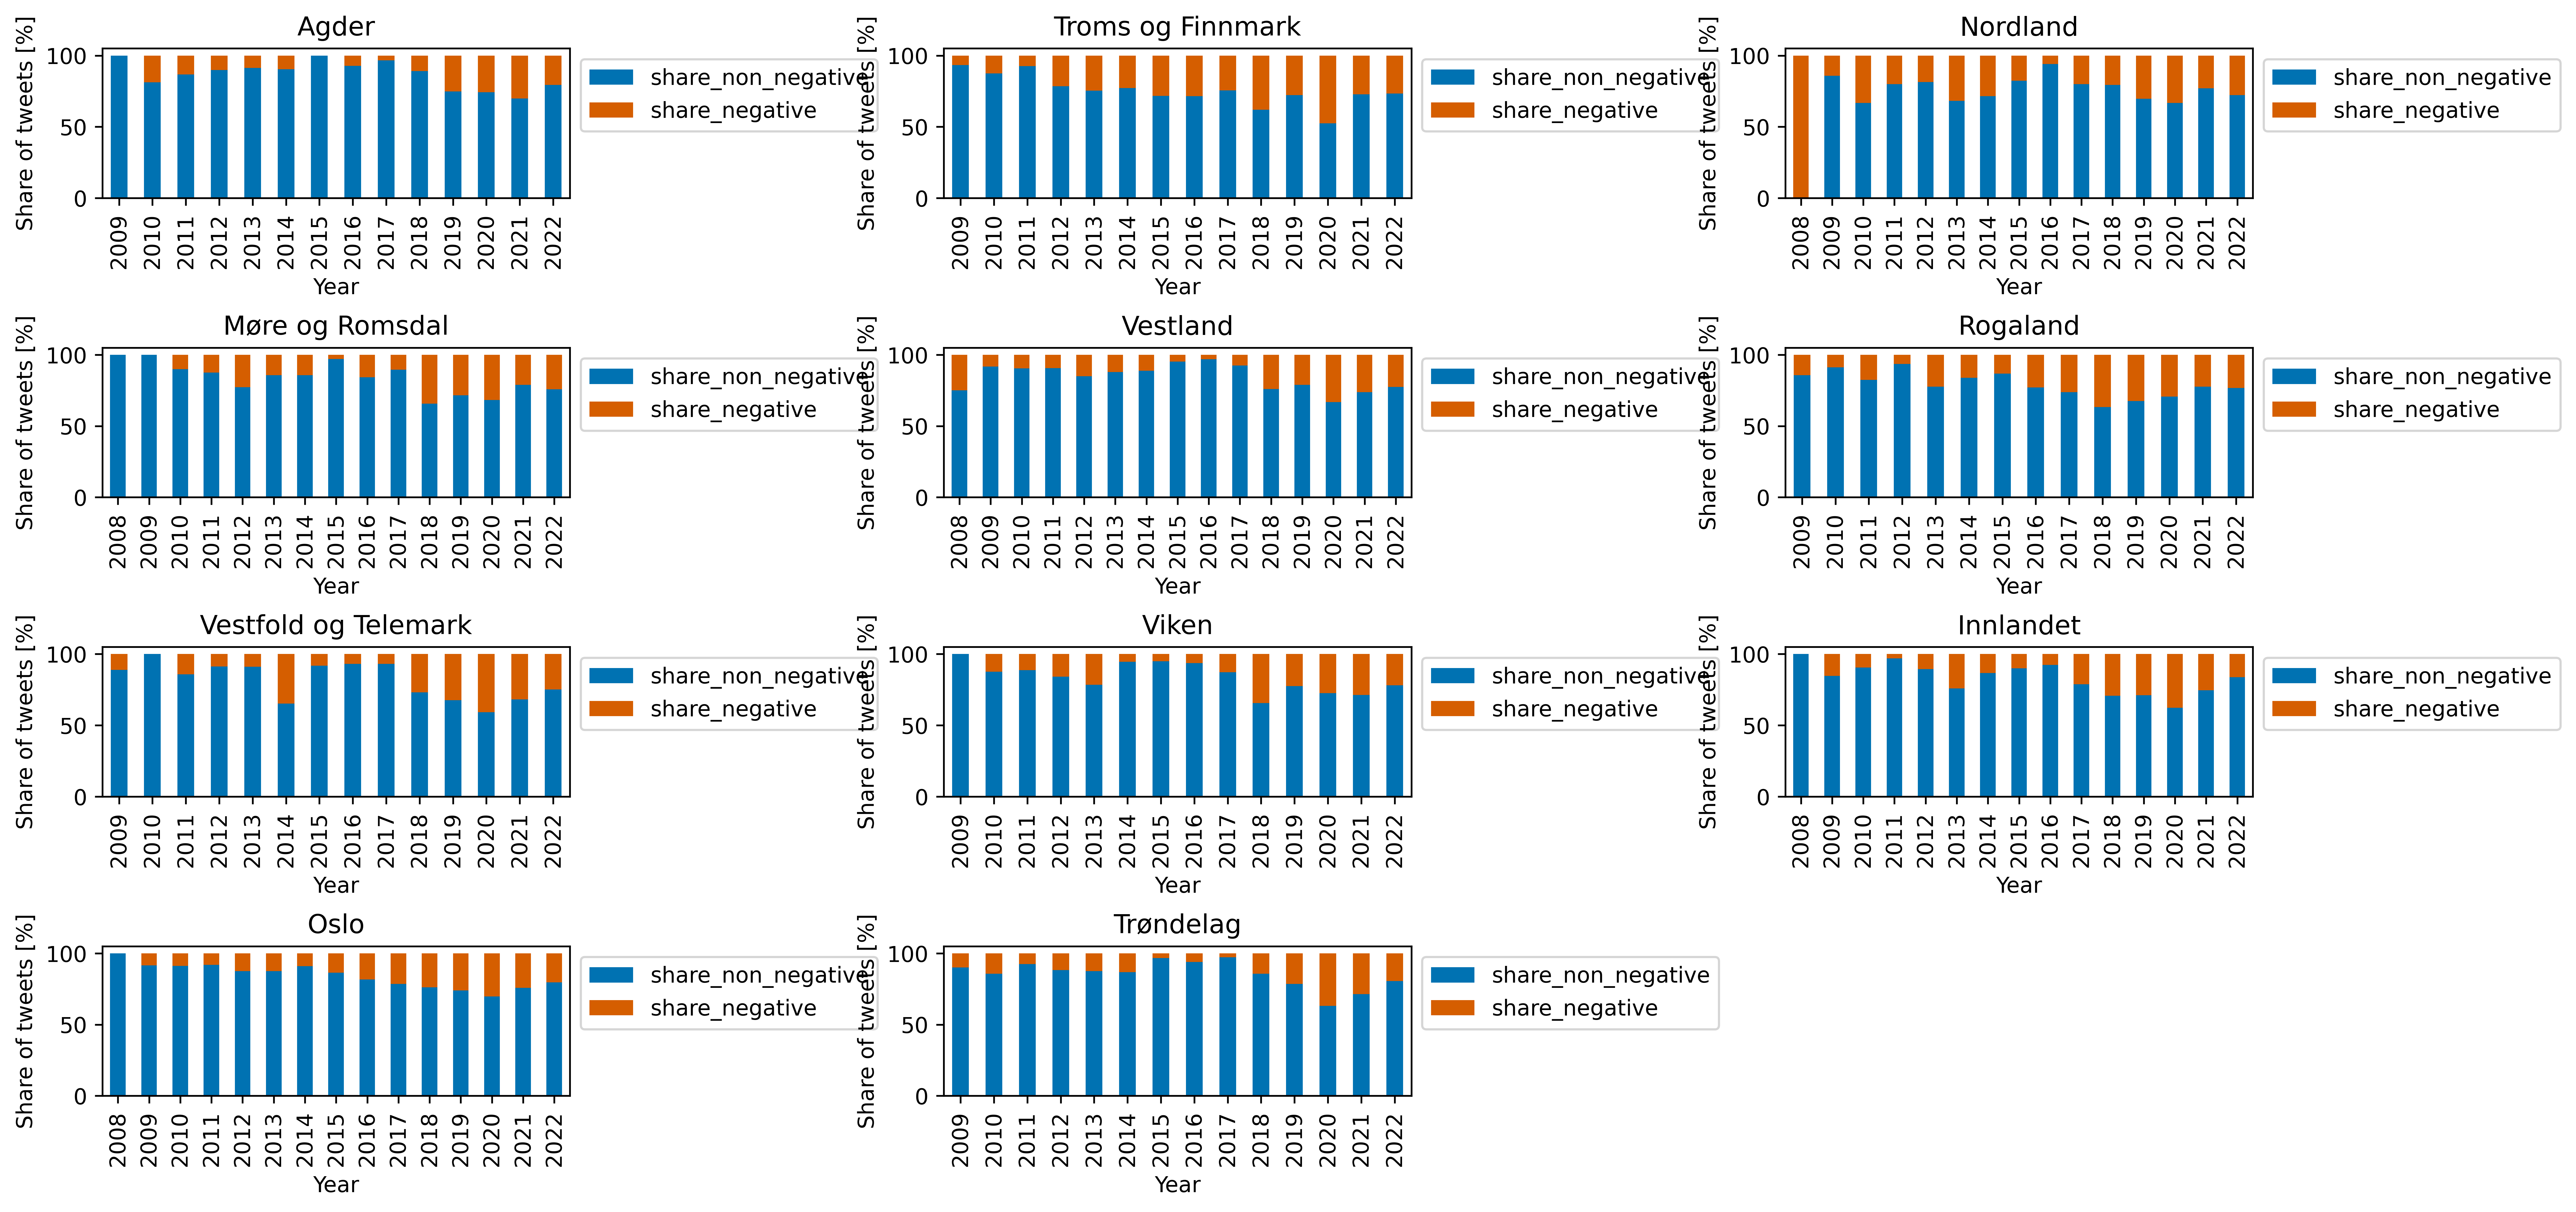

In [28]:
row_nr = 0
column_nr = 0
fig = plt.figure(figsize=(5*3.54,2.5*3.54), dpi=600)

gs = fig.add_gridspec(4,3, wspace = 0.8, hspace = 1)

for county in county_list:
    ax1 = fig.add_subplot(gs[row_nr,column_nr])
    gdf = gdf_yearly_county.loc[gdf_yearly_county['NUTS_NAME'] == str(county)]
    gdf.groupby(
        'year'
    ).count(
    ).rename(
        columns={
            'label' : 'total_tweets'
        }
    ).assign(
        non_negative_tweets = gdf.groupby('year').sum().label,
        negative_tweets = lambda x : x.total_tweets - x.non_negative_tweets,
        share_negative = lambda x: 100*x.negative_tweets/x.total_tweets,
        share_non_negative = lambda x: 100-x.share_negative
    ).drop(
        columns={
            'geometry',
            'NUTS_NAME',
            #'label',
            'created_at'
        }
    ).plot.bar(
        title = county,
        y = ['share_non_negative','share_negative'],
        stacked = True,
        ax=ax1,
        color = [blue, vermilion],
    )
    
    column_nr += 1
    if column_nr == 3:
        column_nr = 0
        row_nr += 1
    plt.legend(bbox_to_anchor =(1,1))
    plt.xlabel('Year')
    plt.ylabel('Share of tweets [%]')
    #plt.savefig('figures/all_counties_temporal_bar.eps')

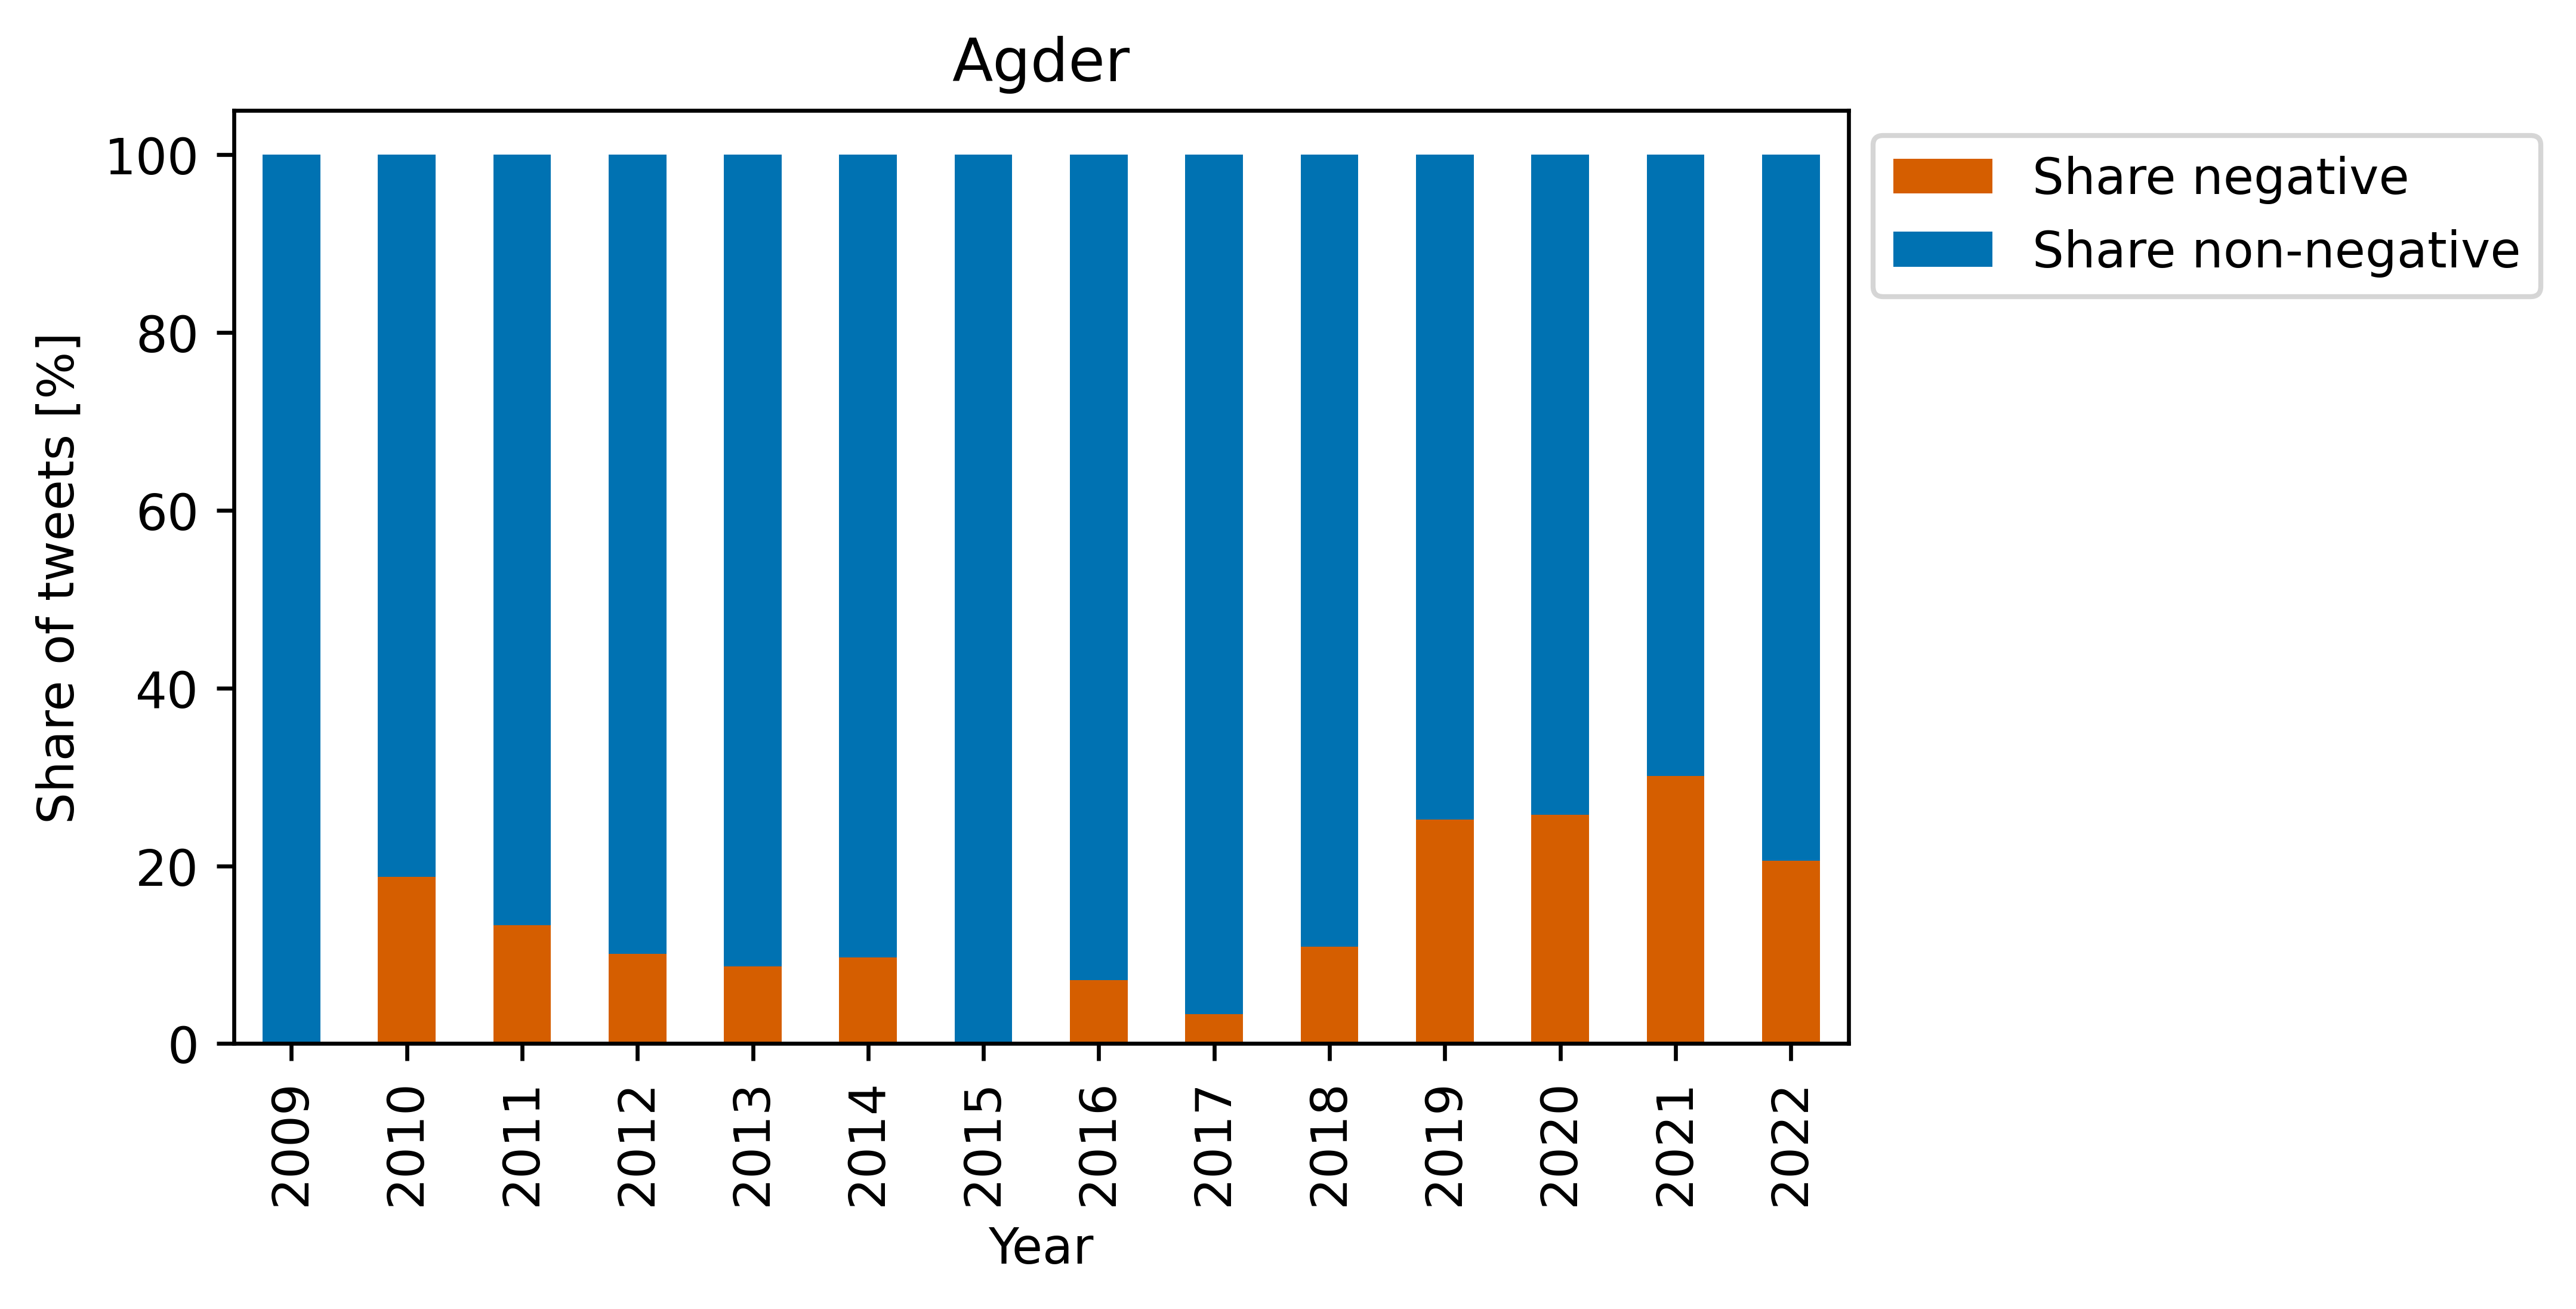

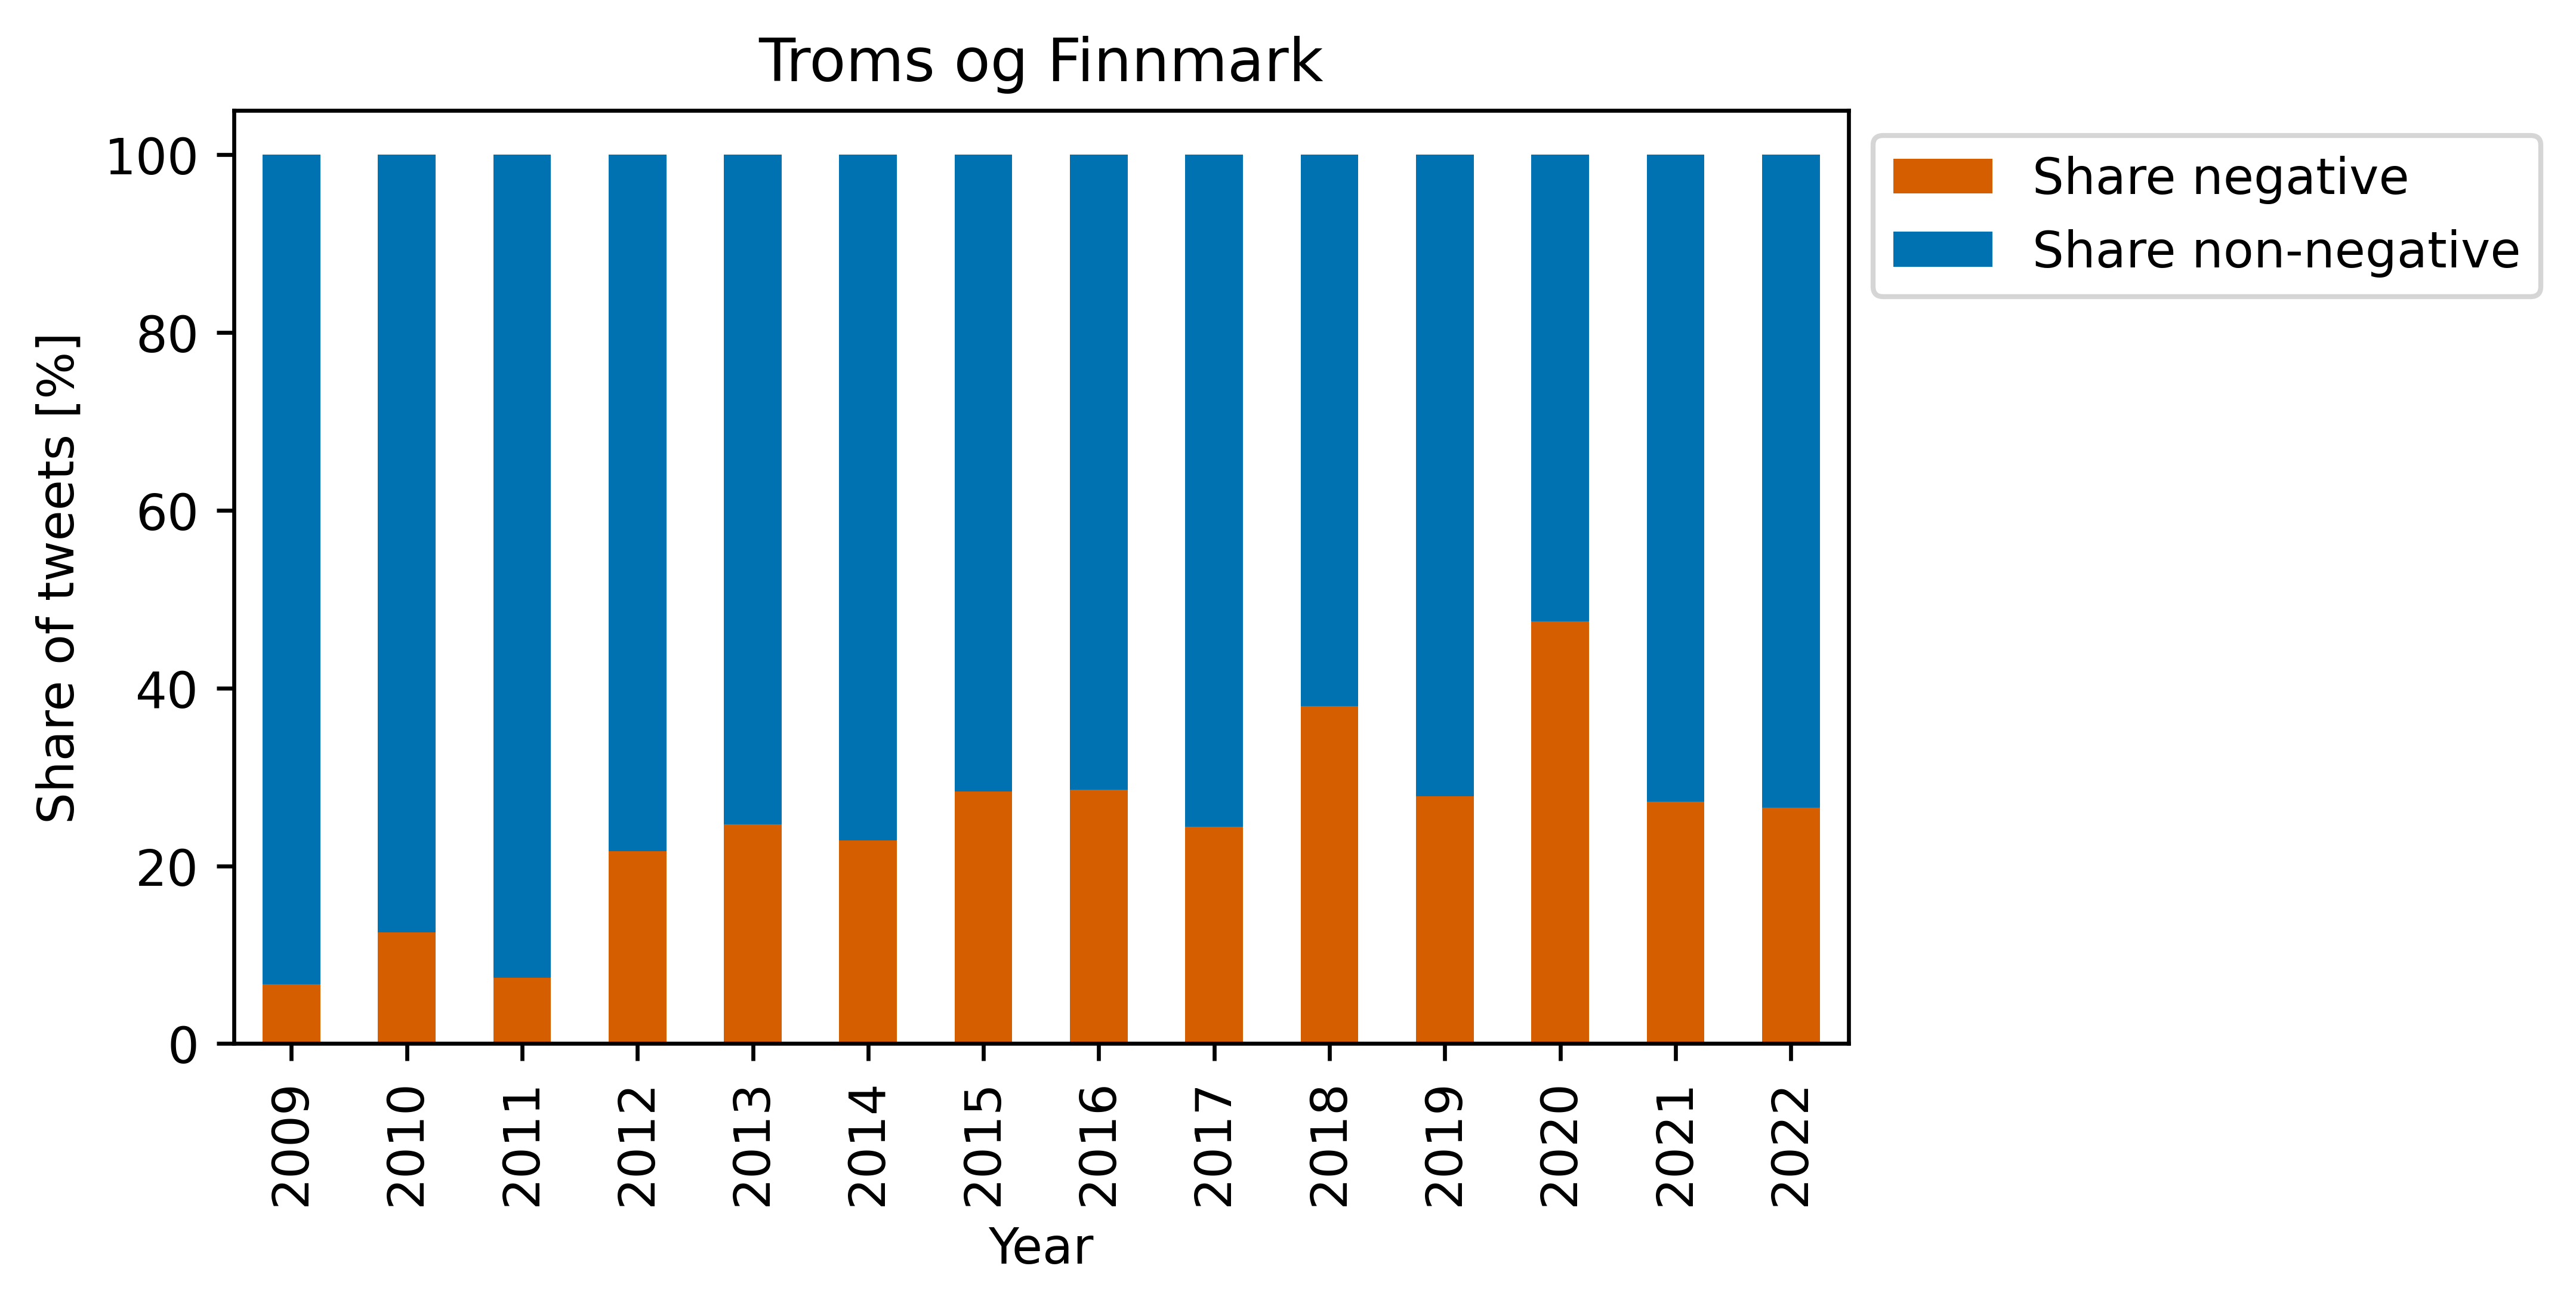

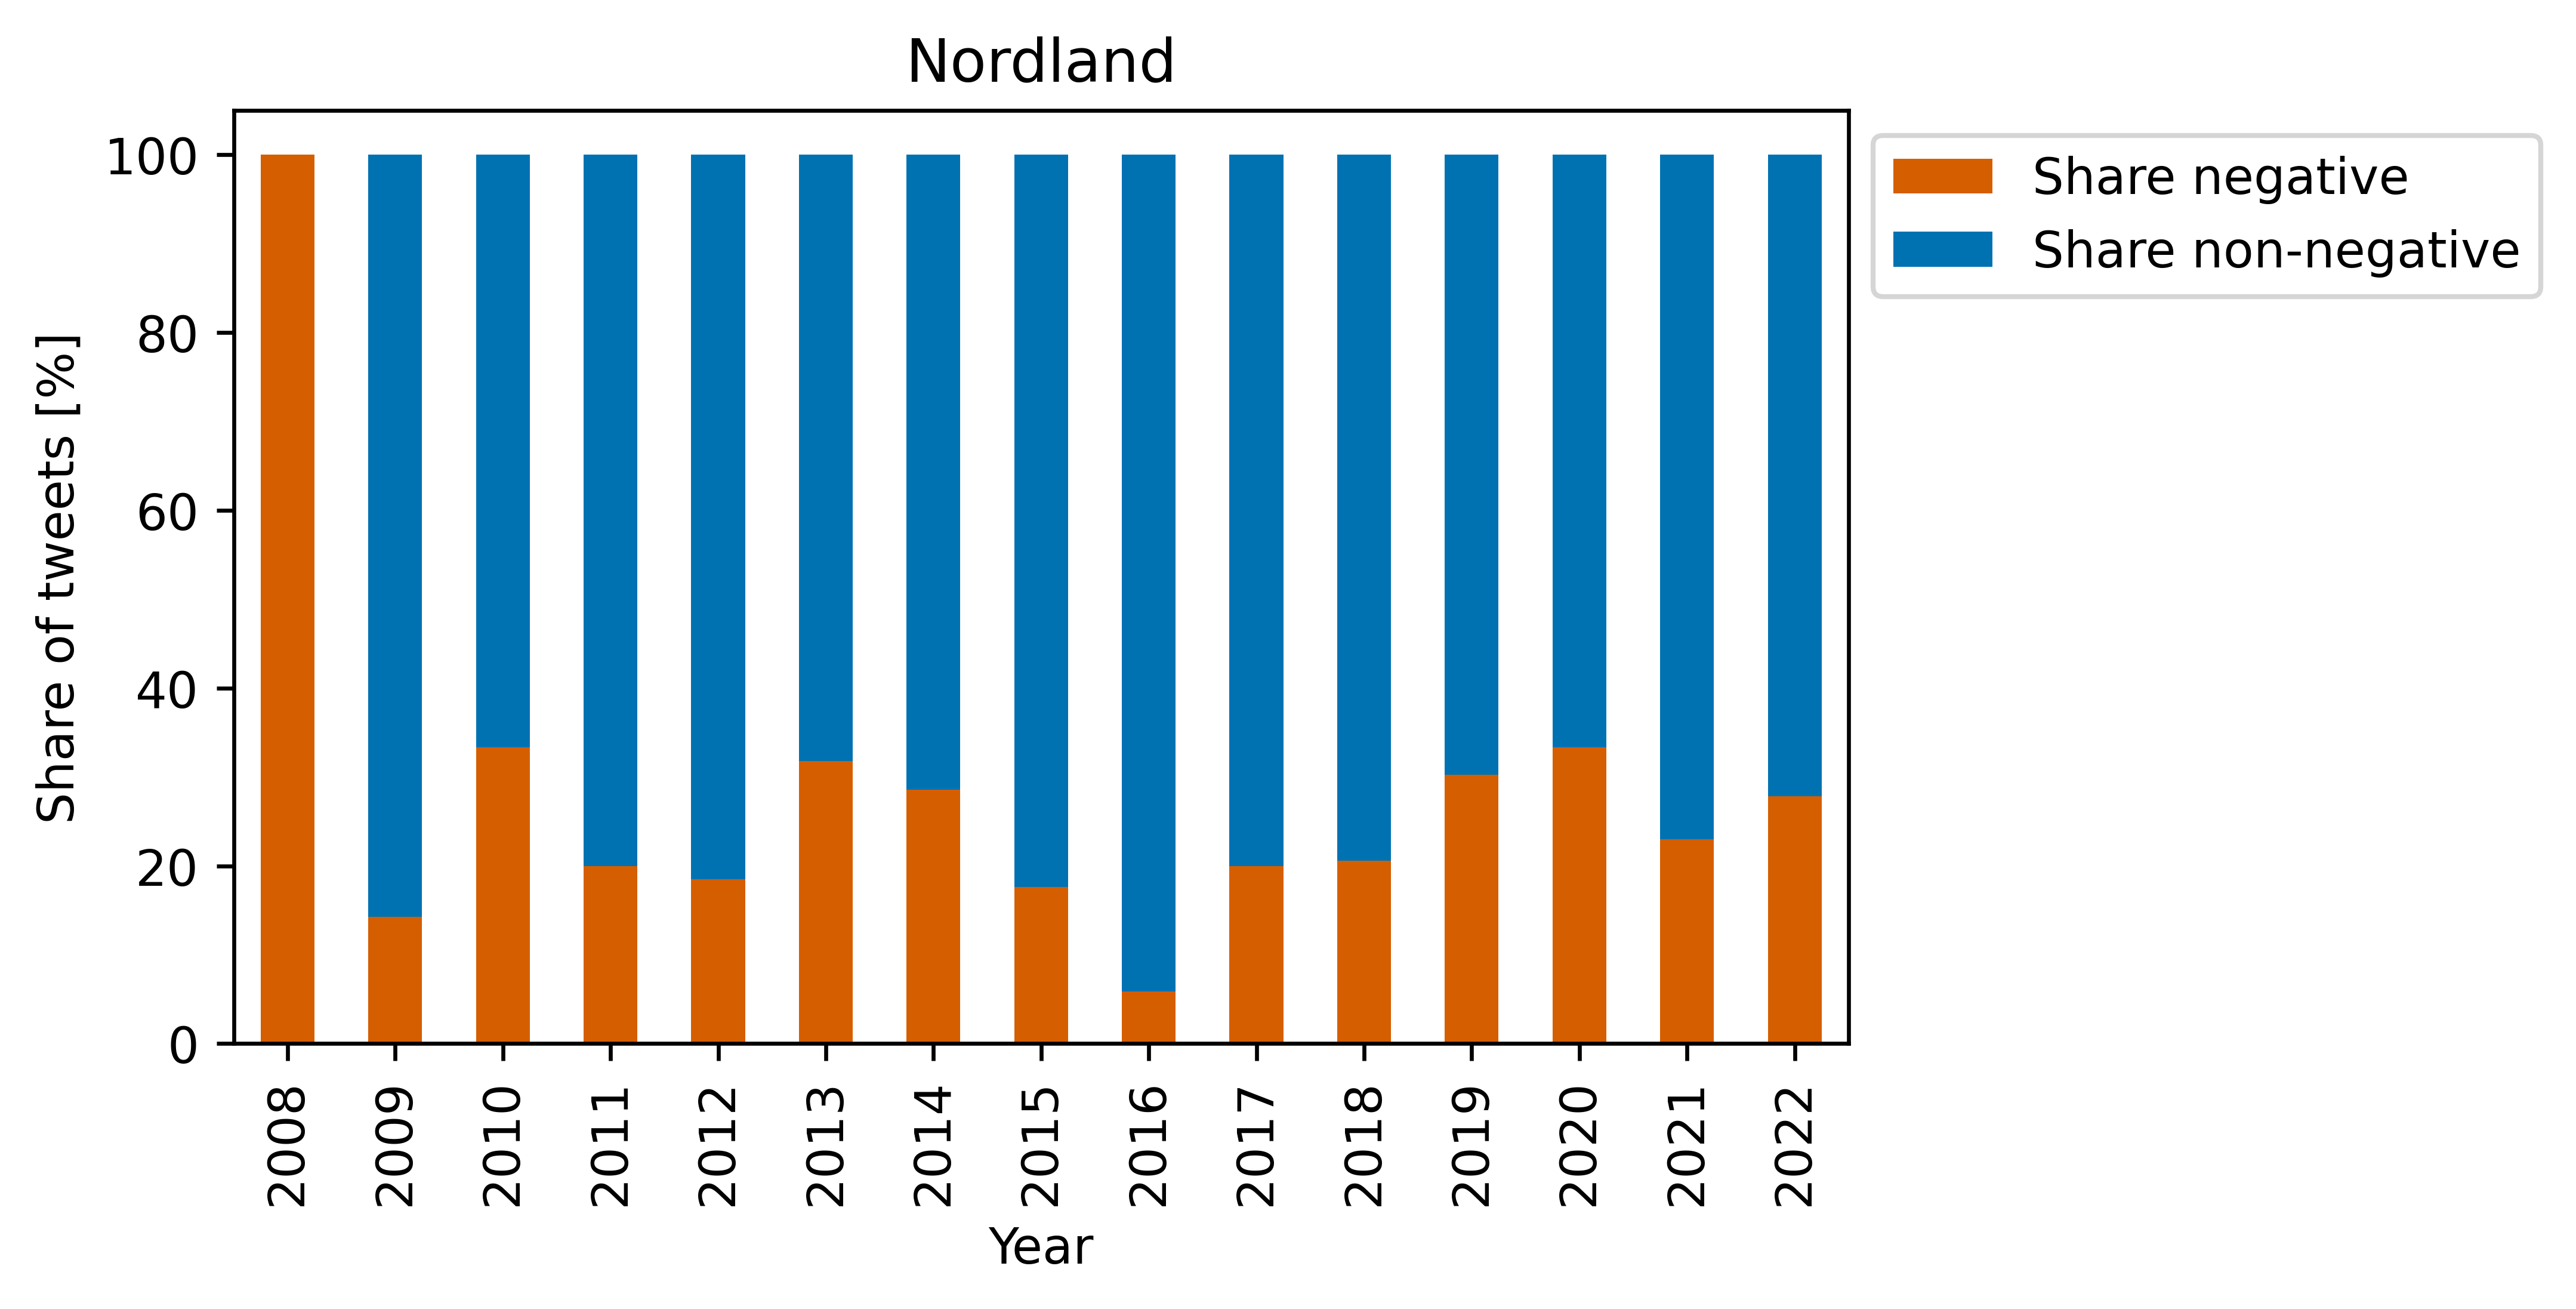

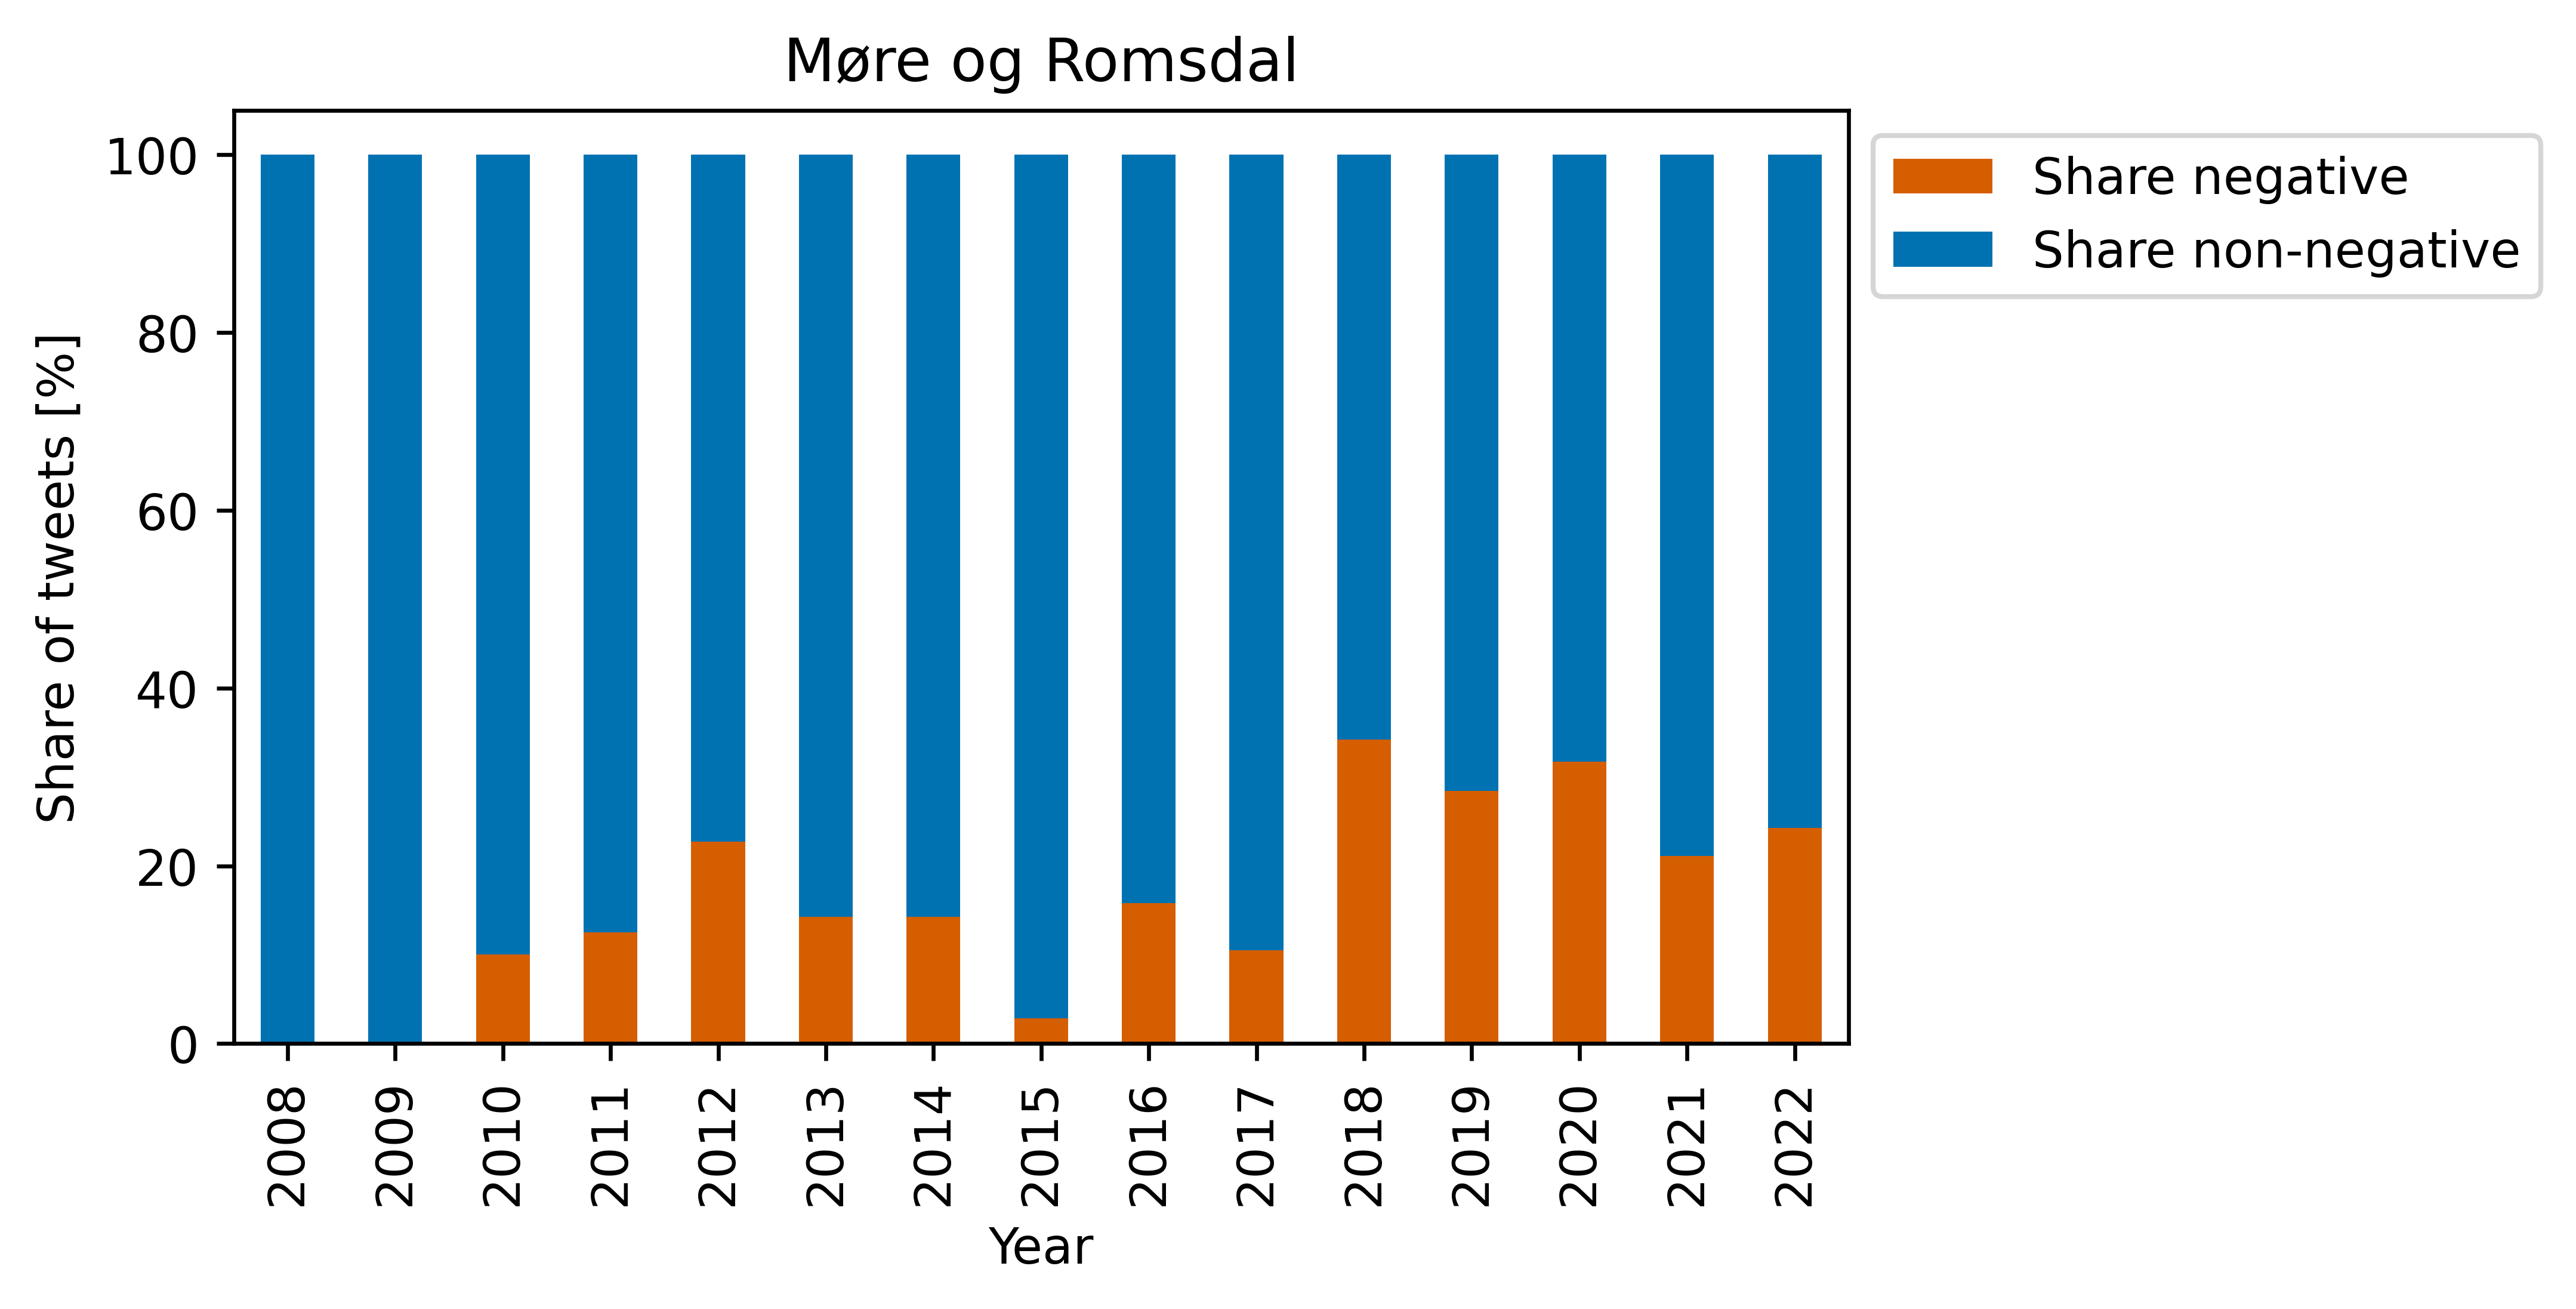

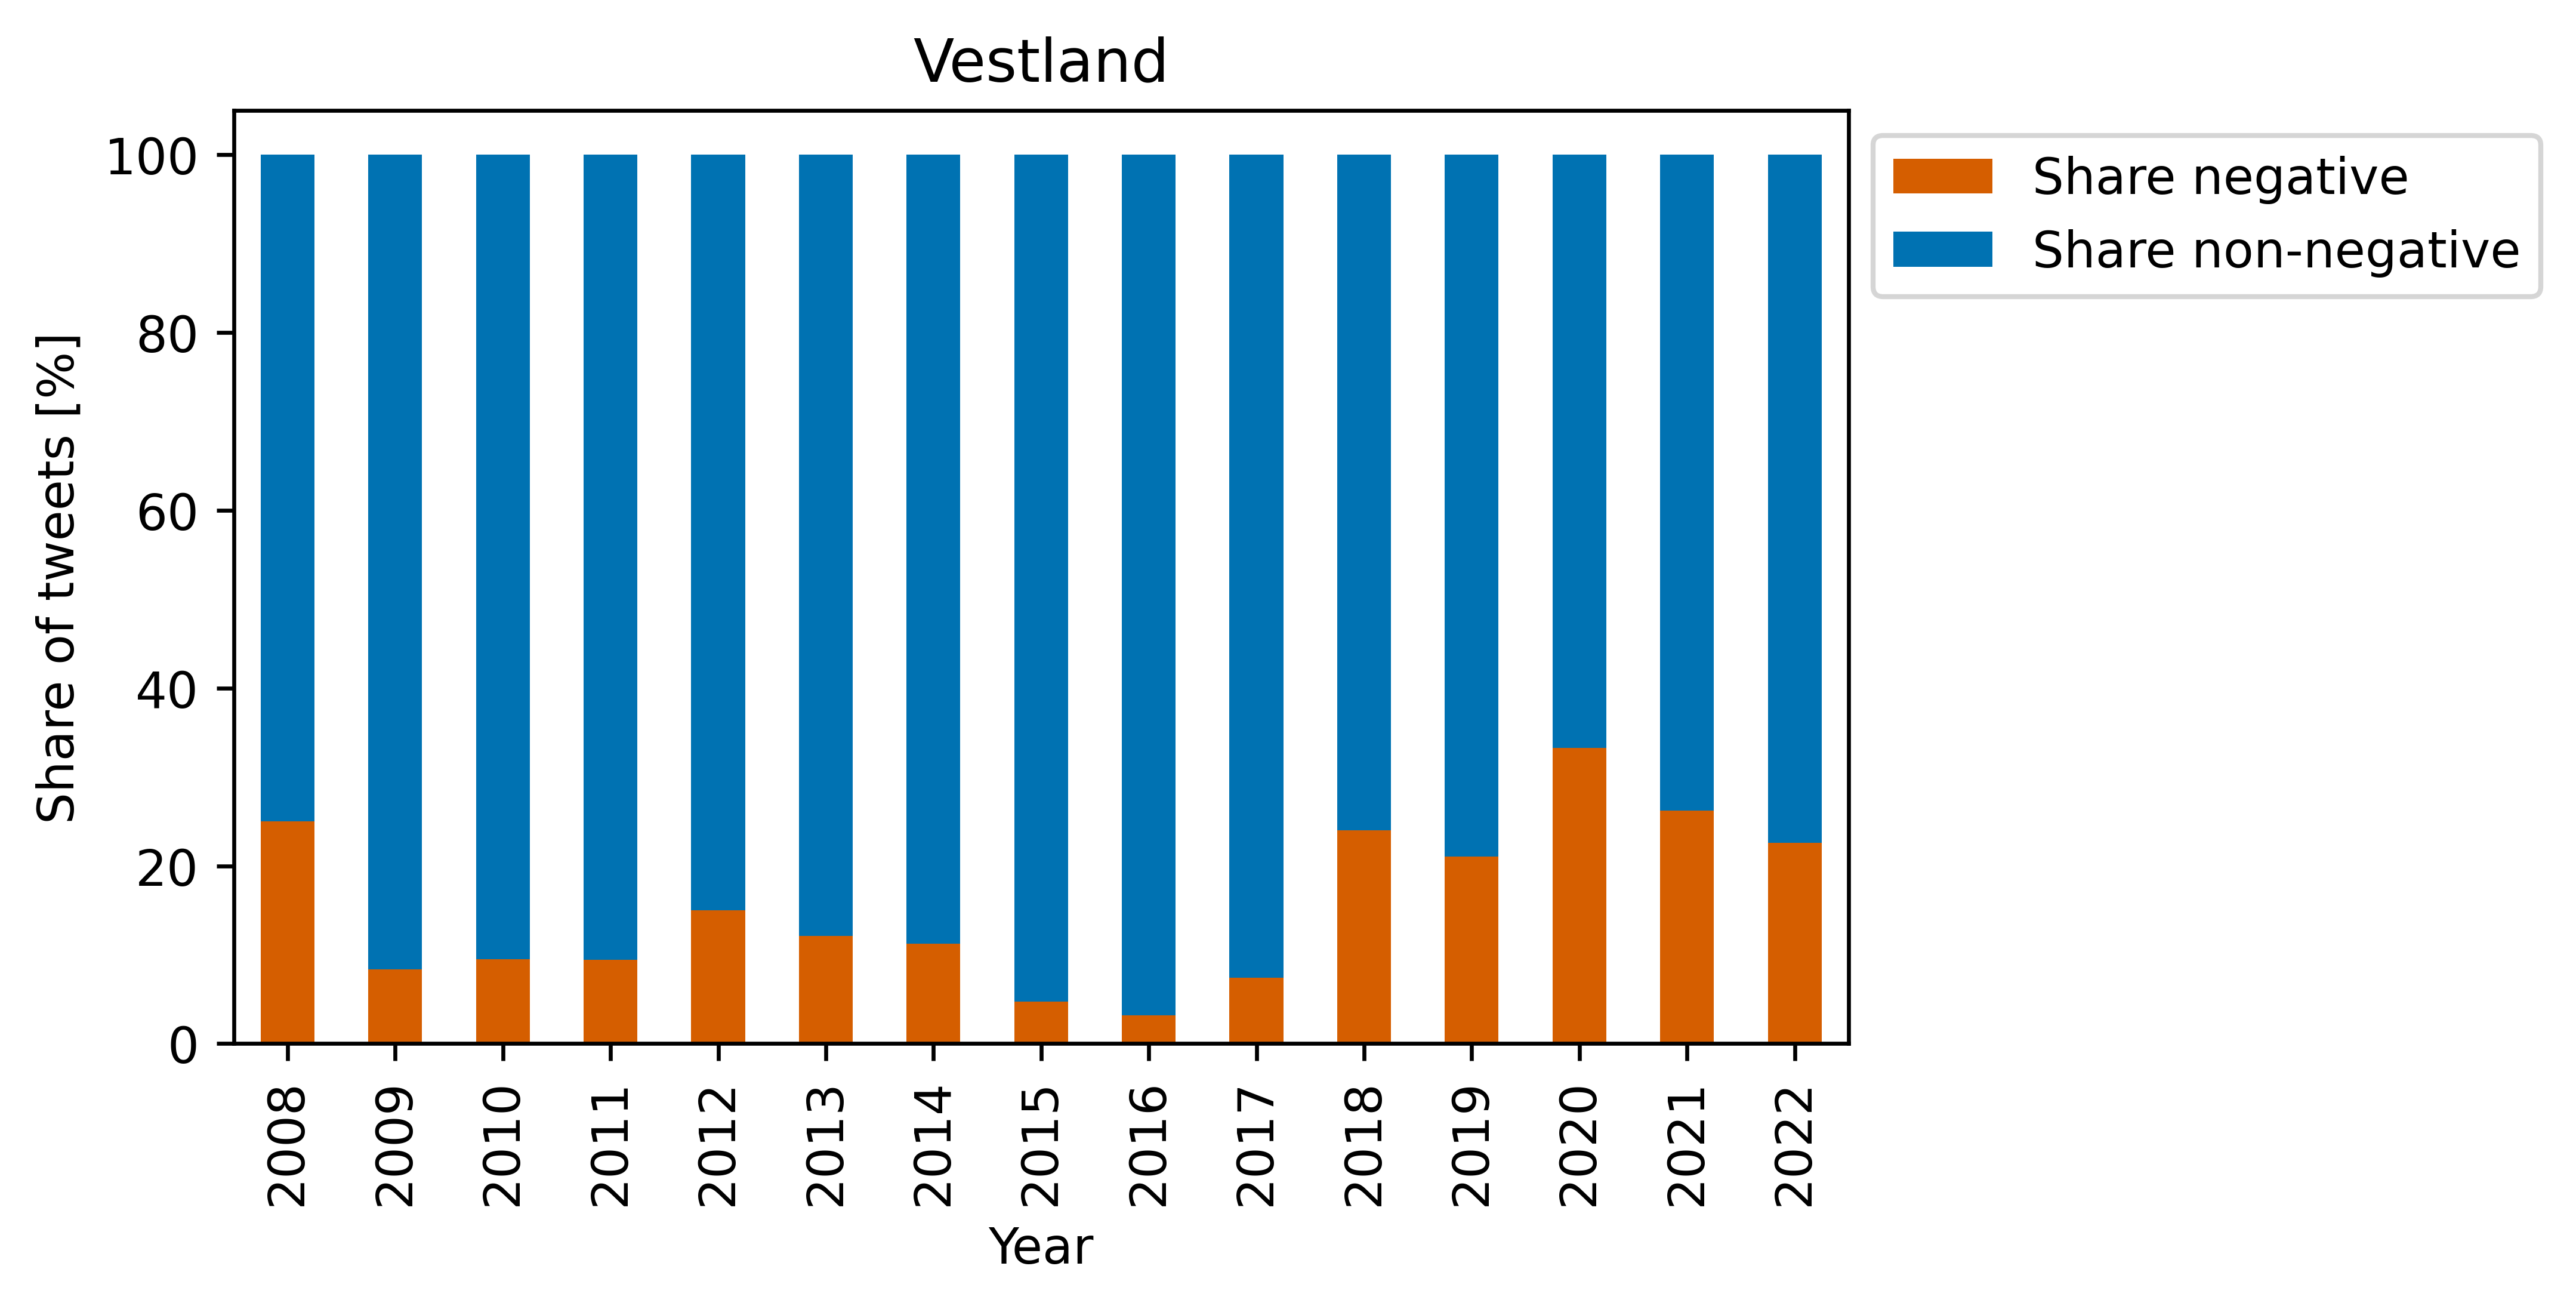

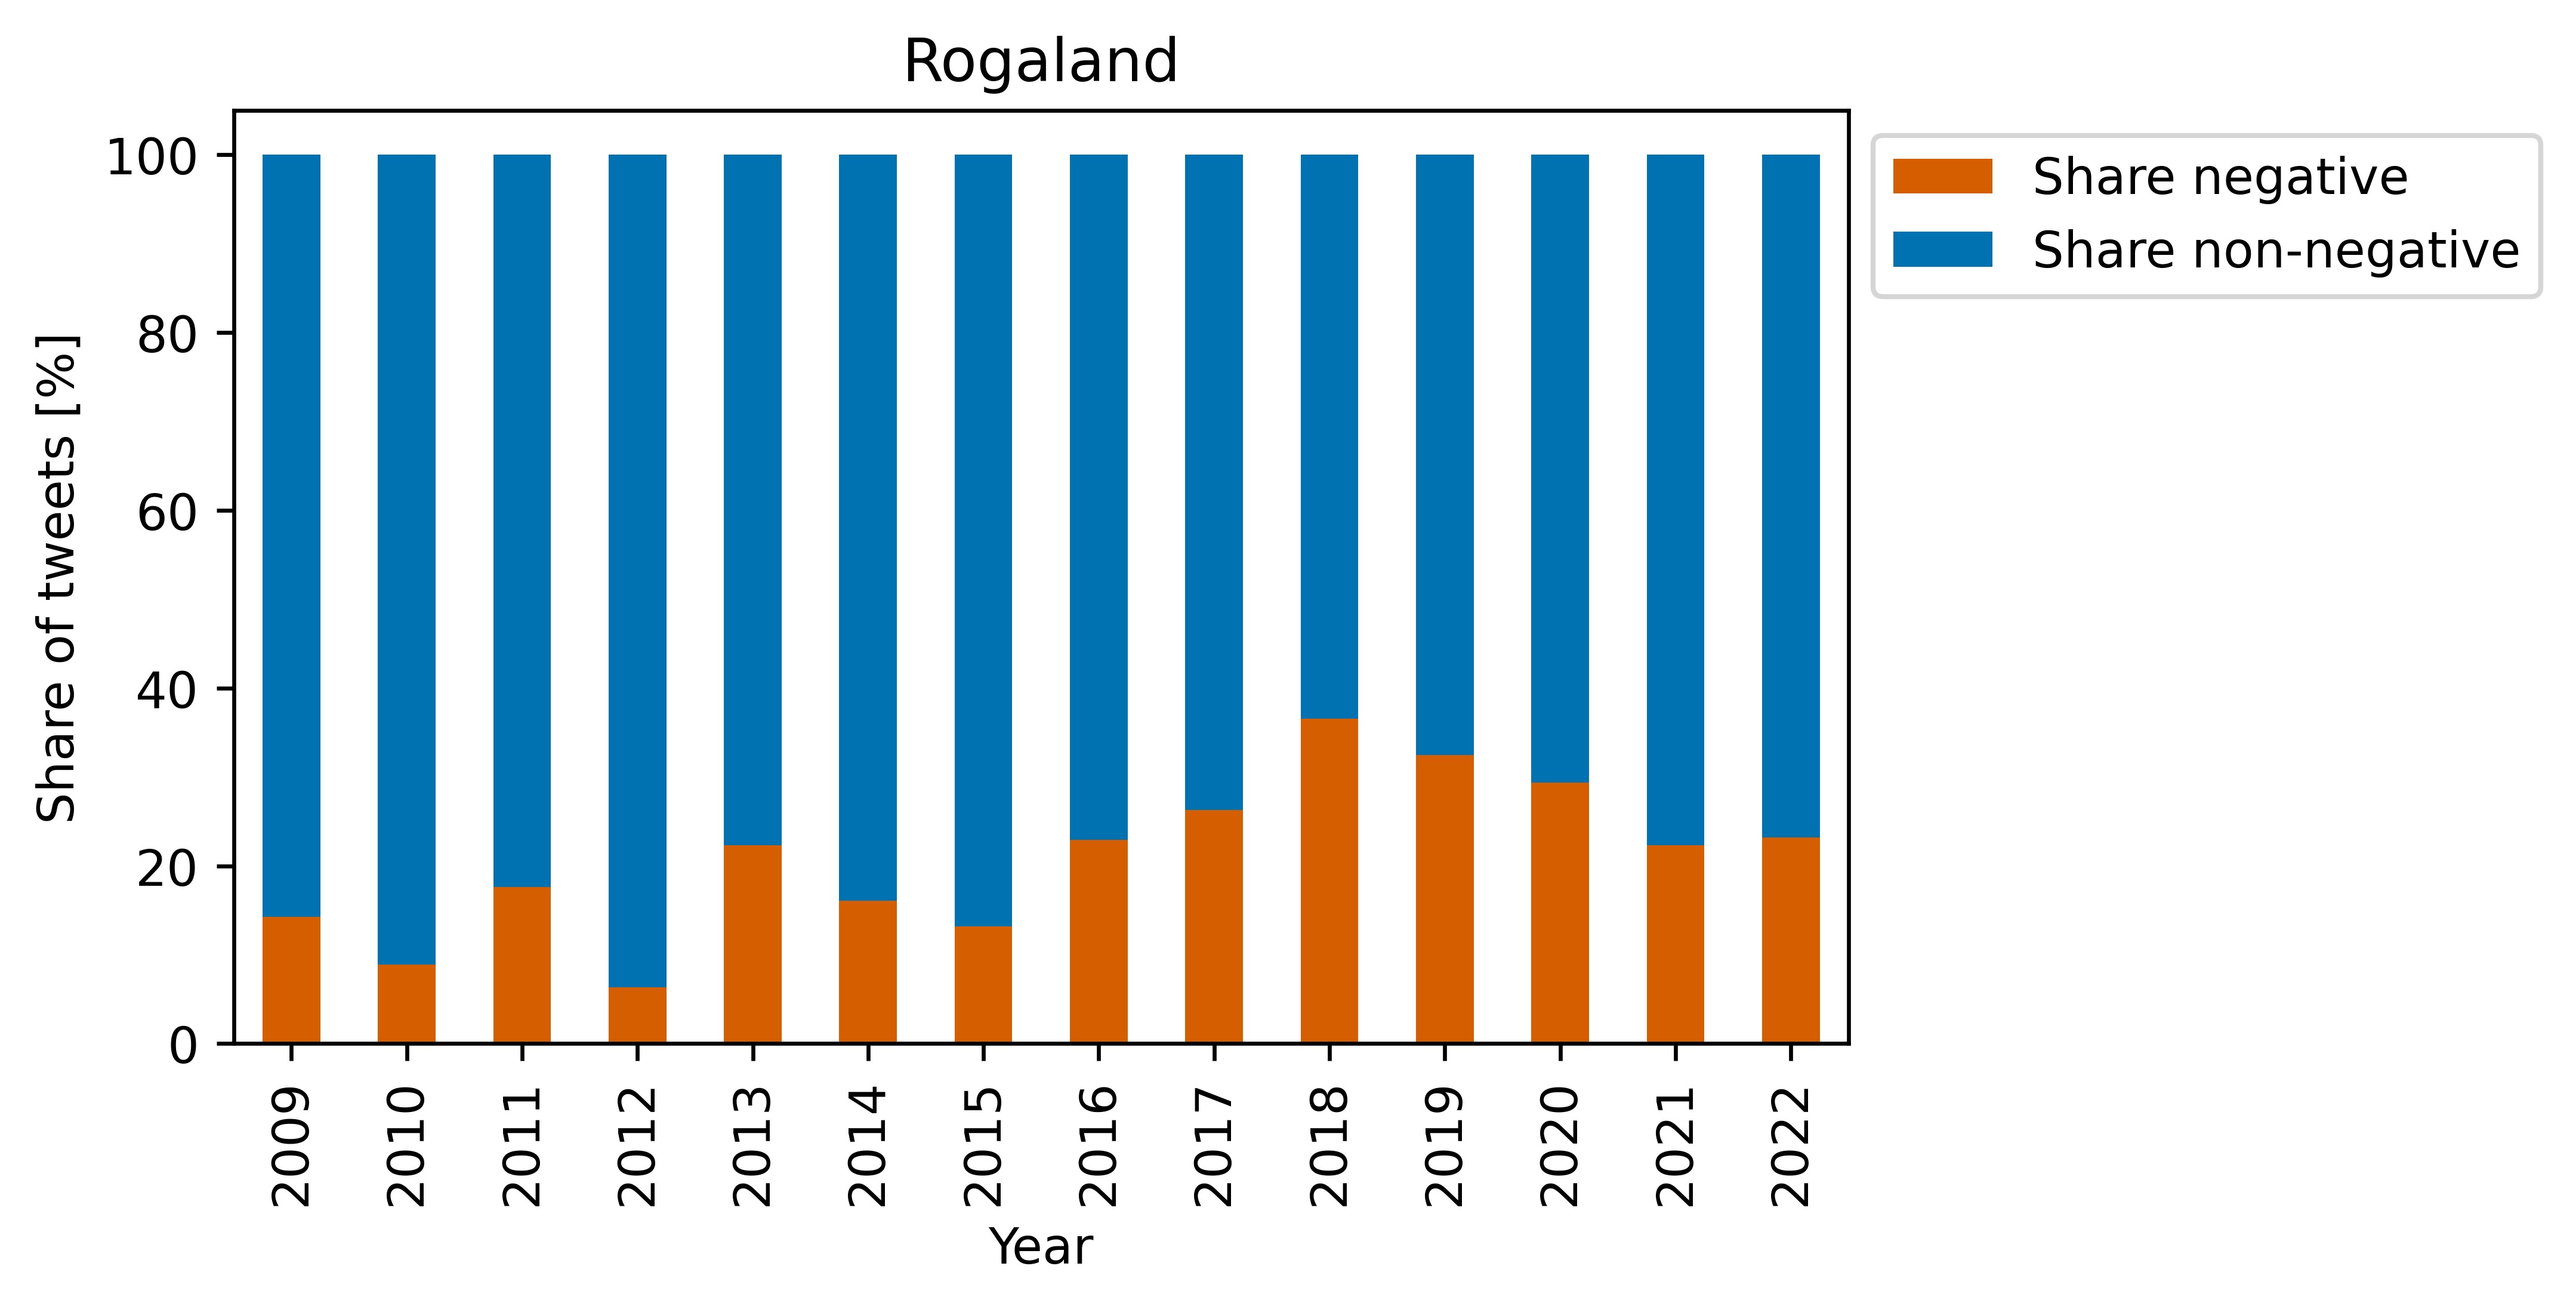

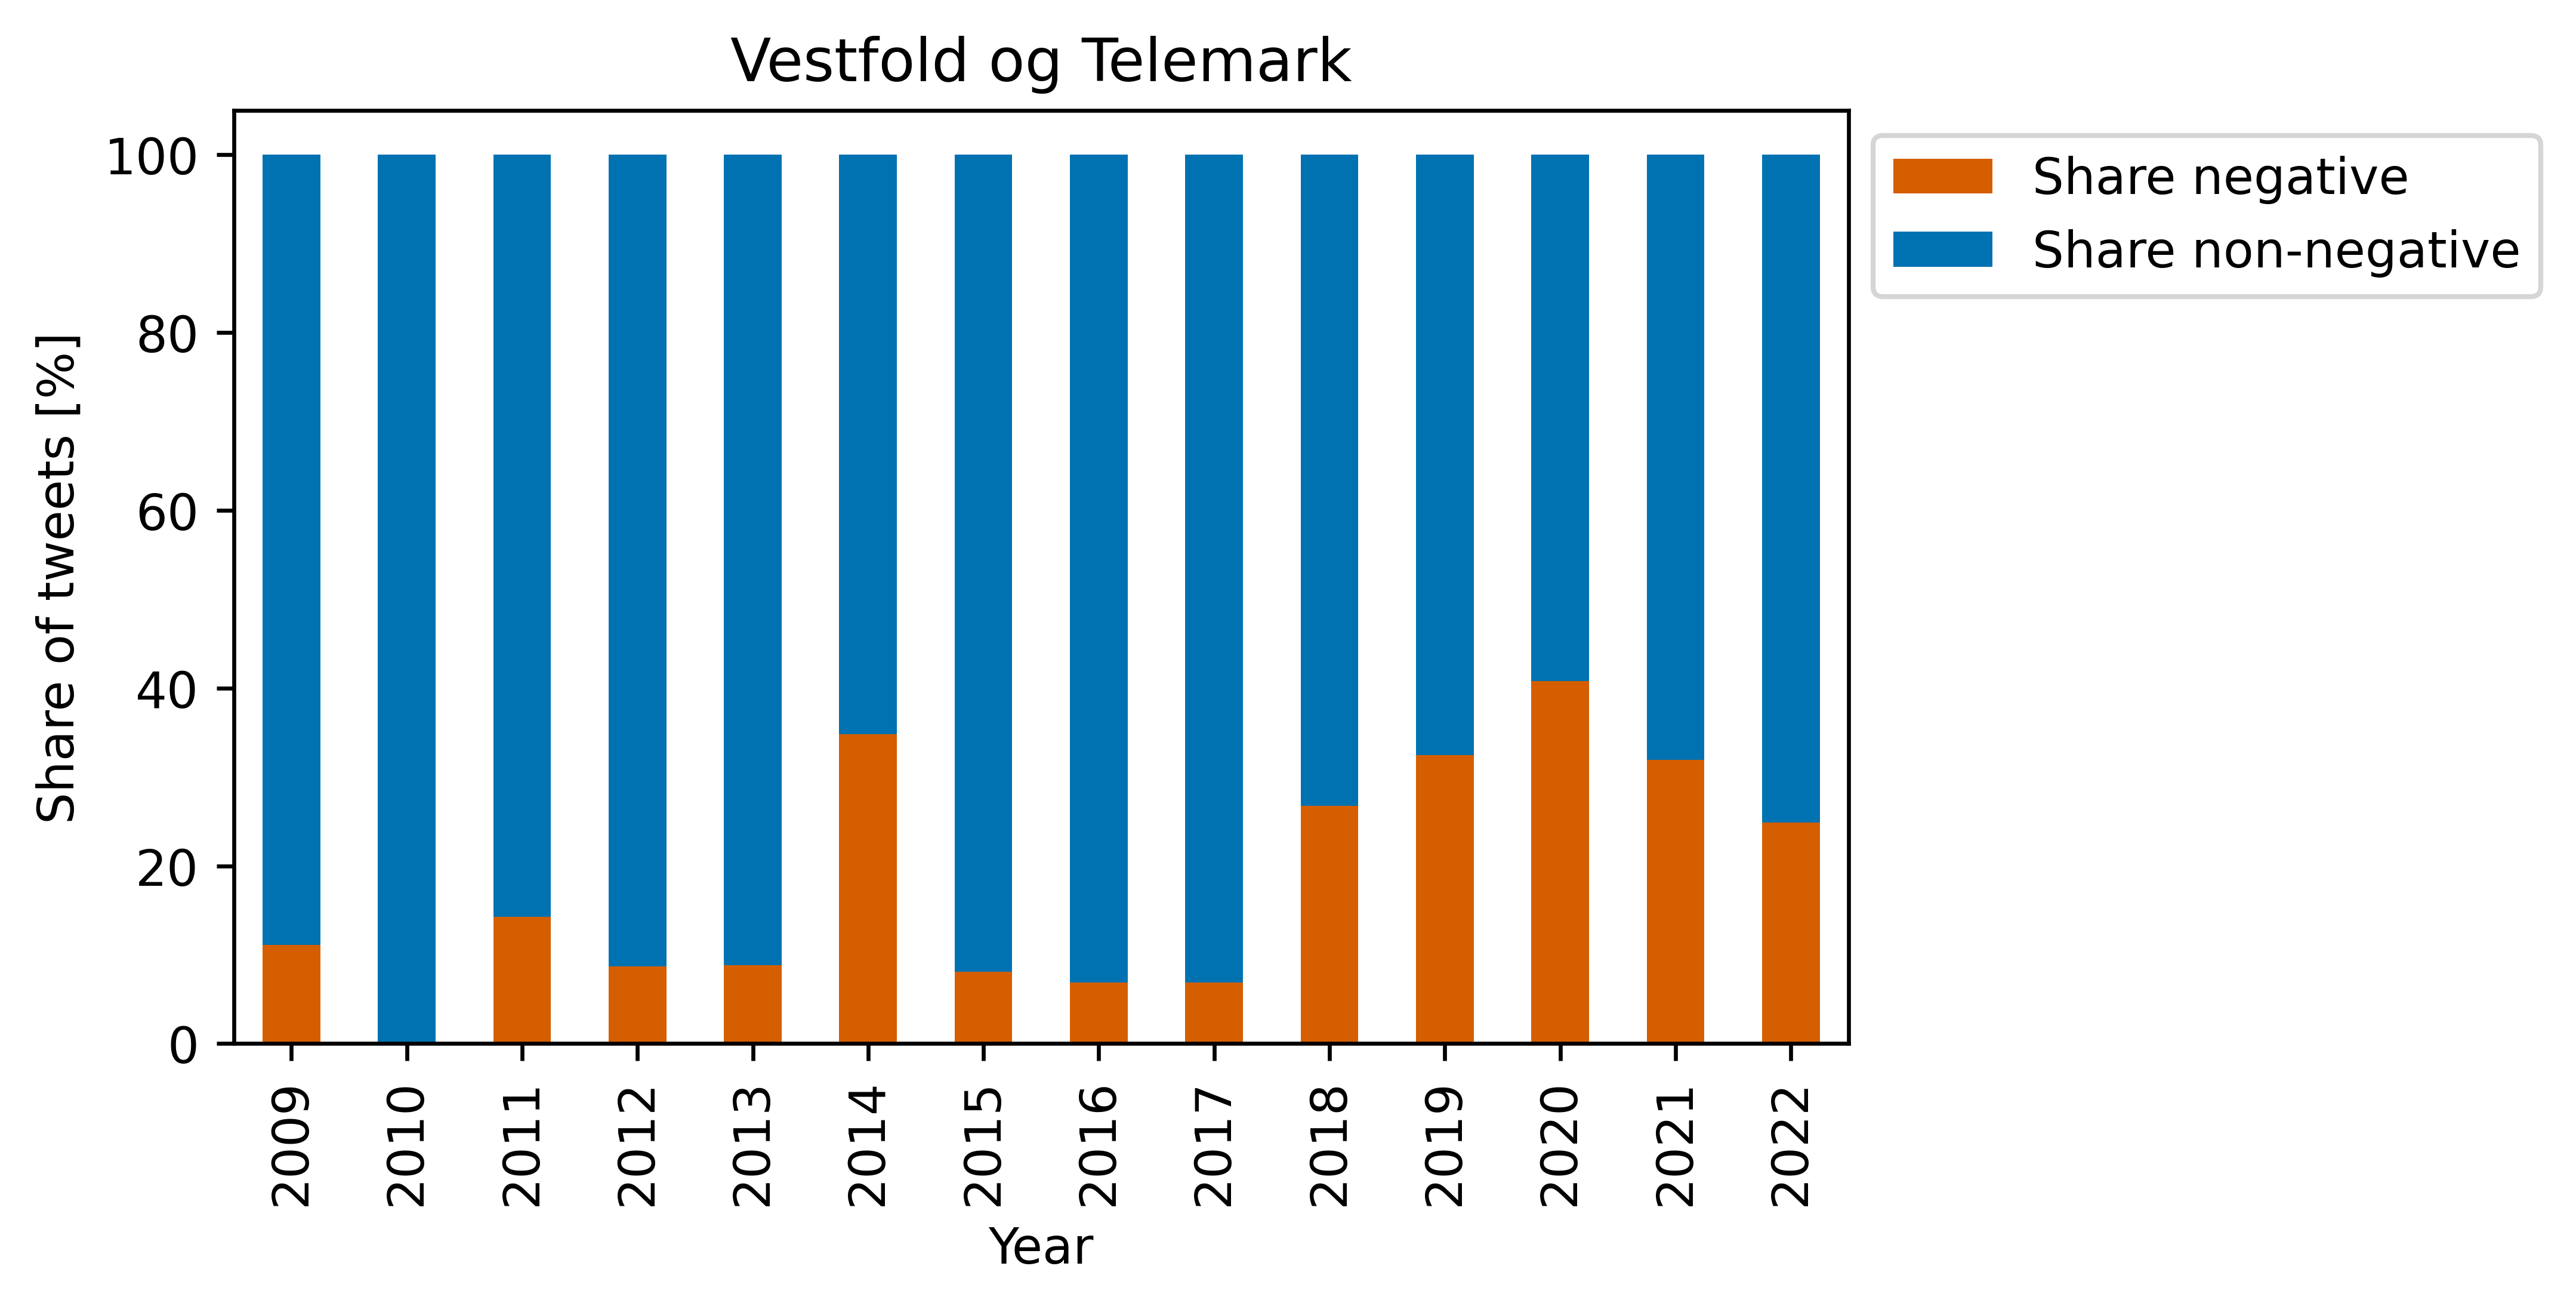

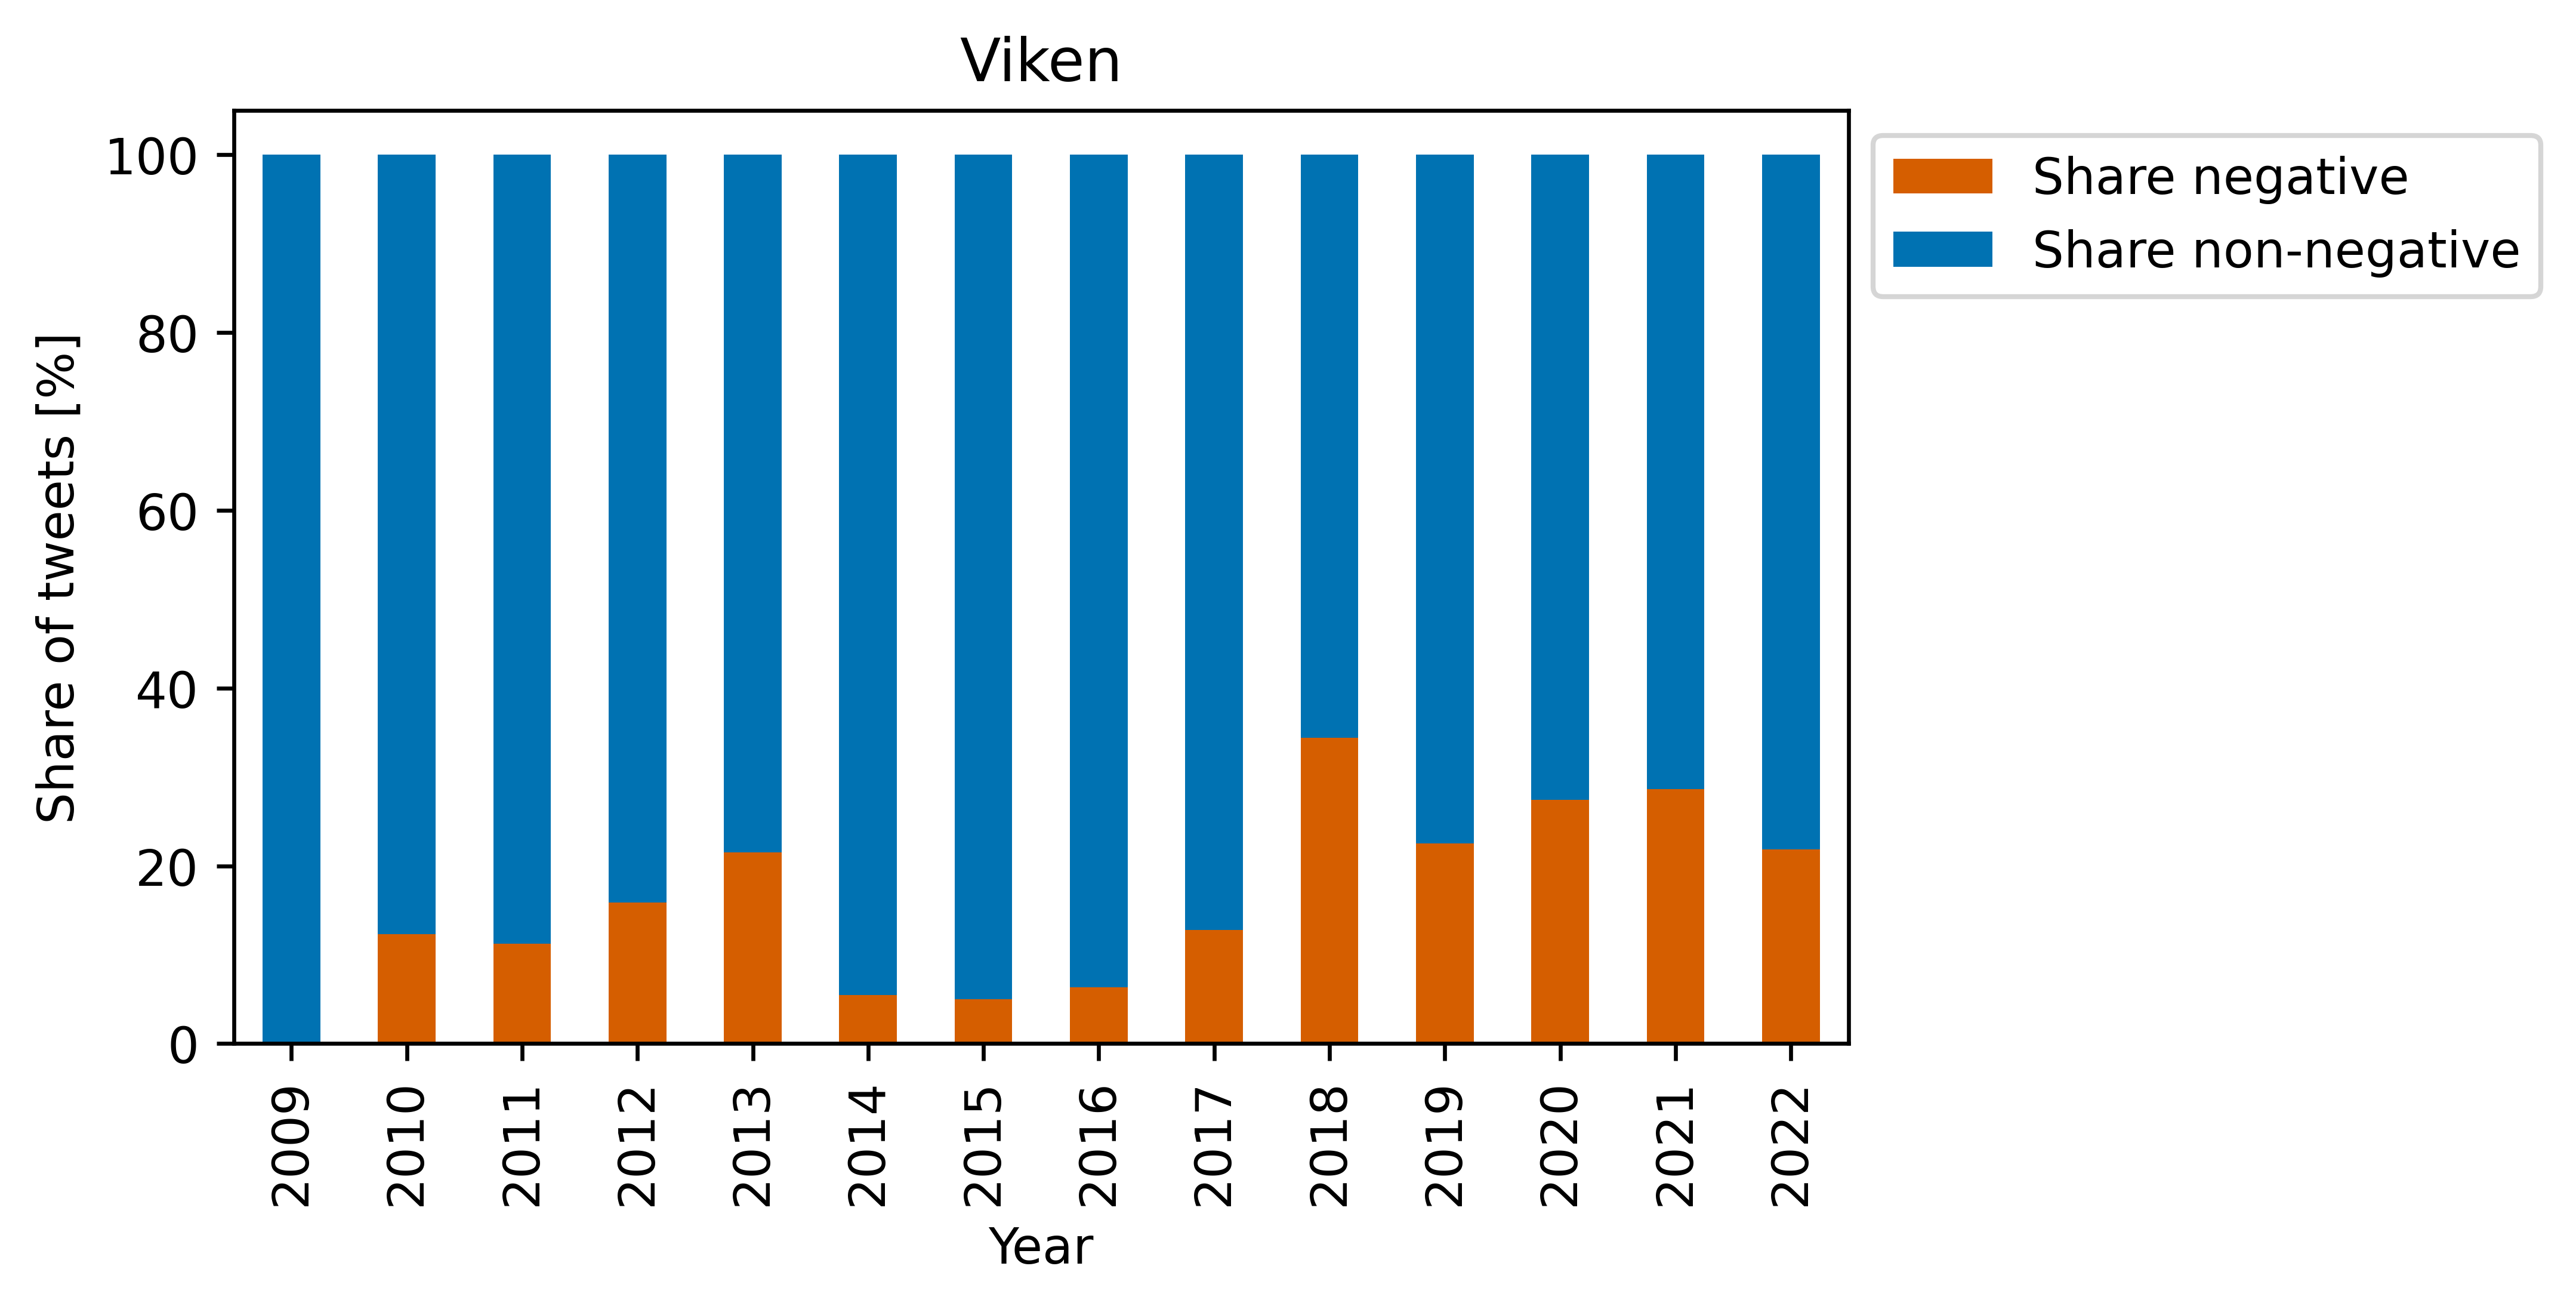

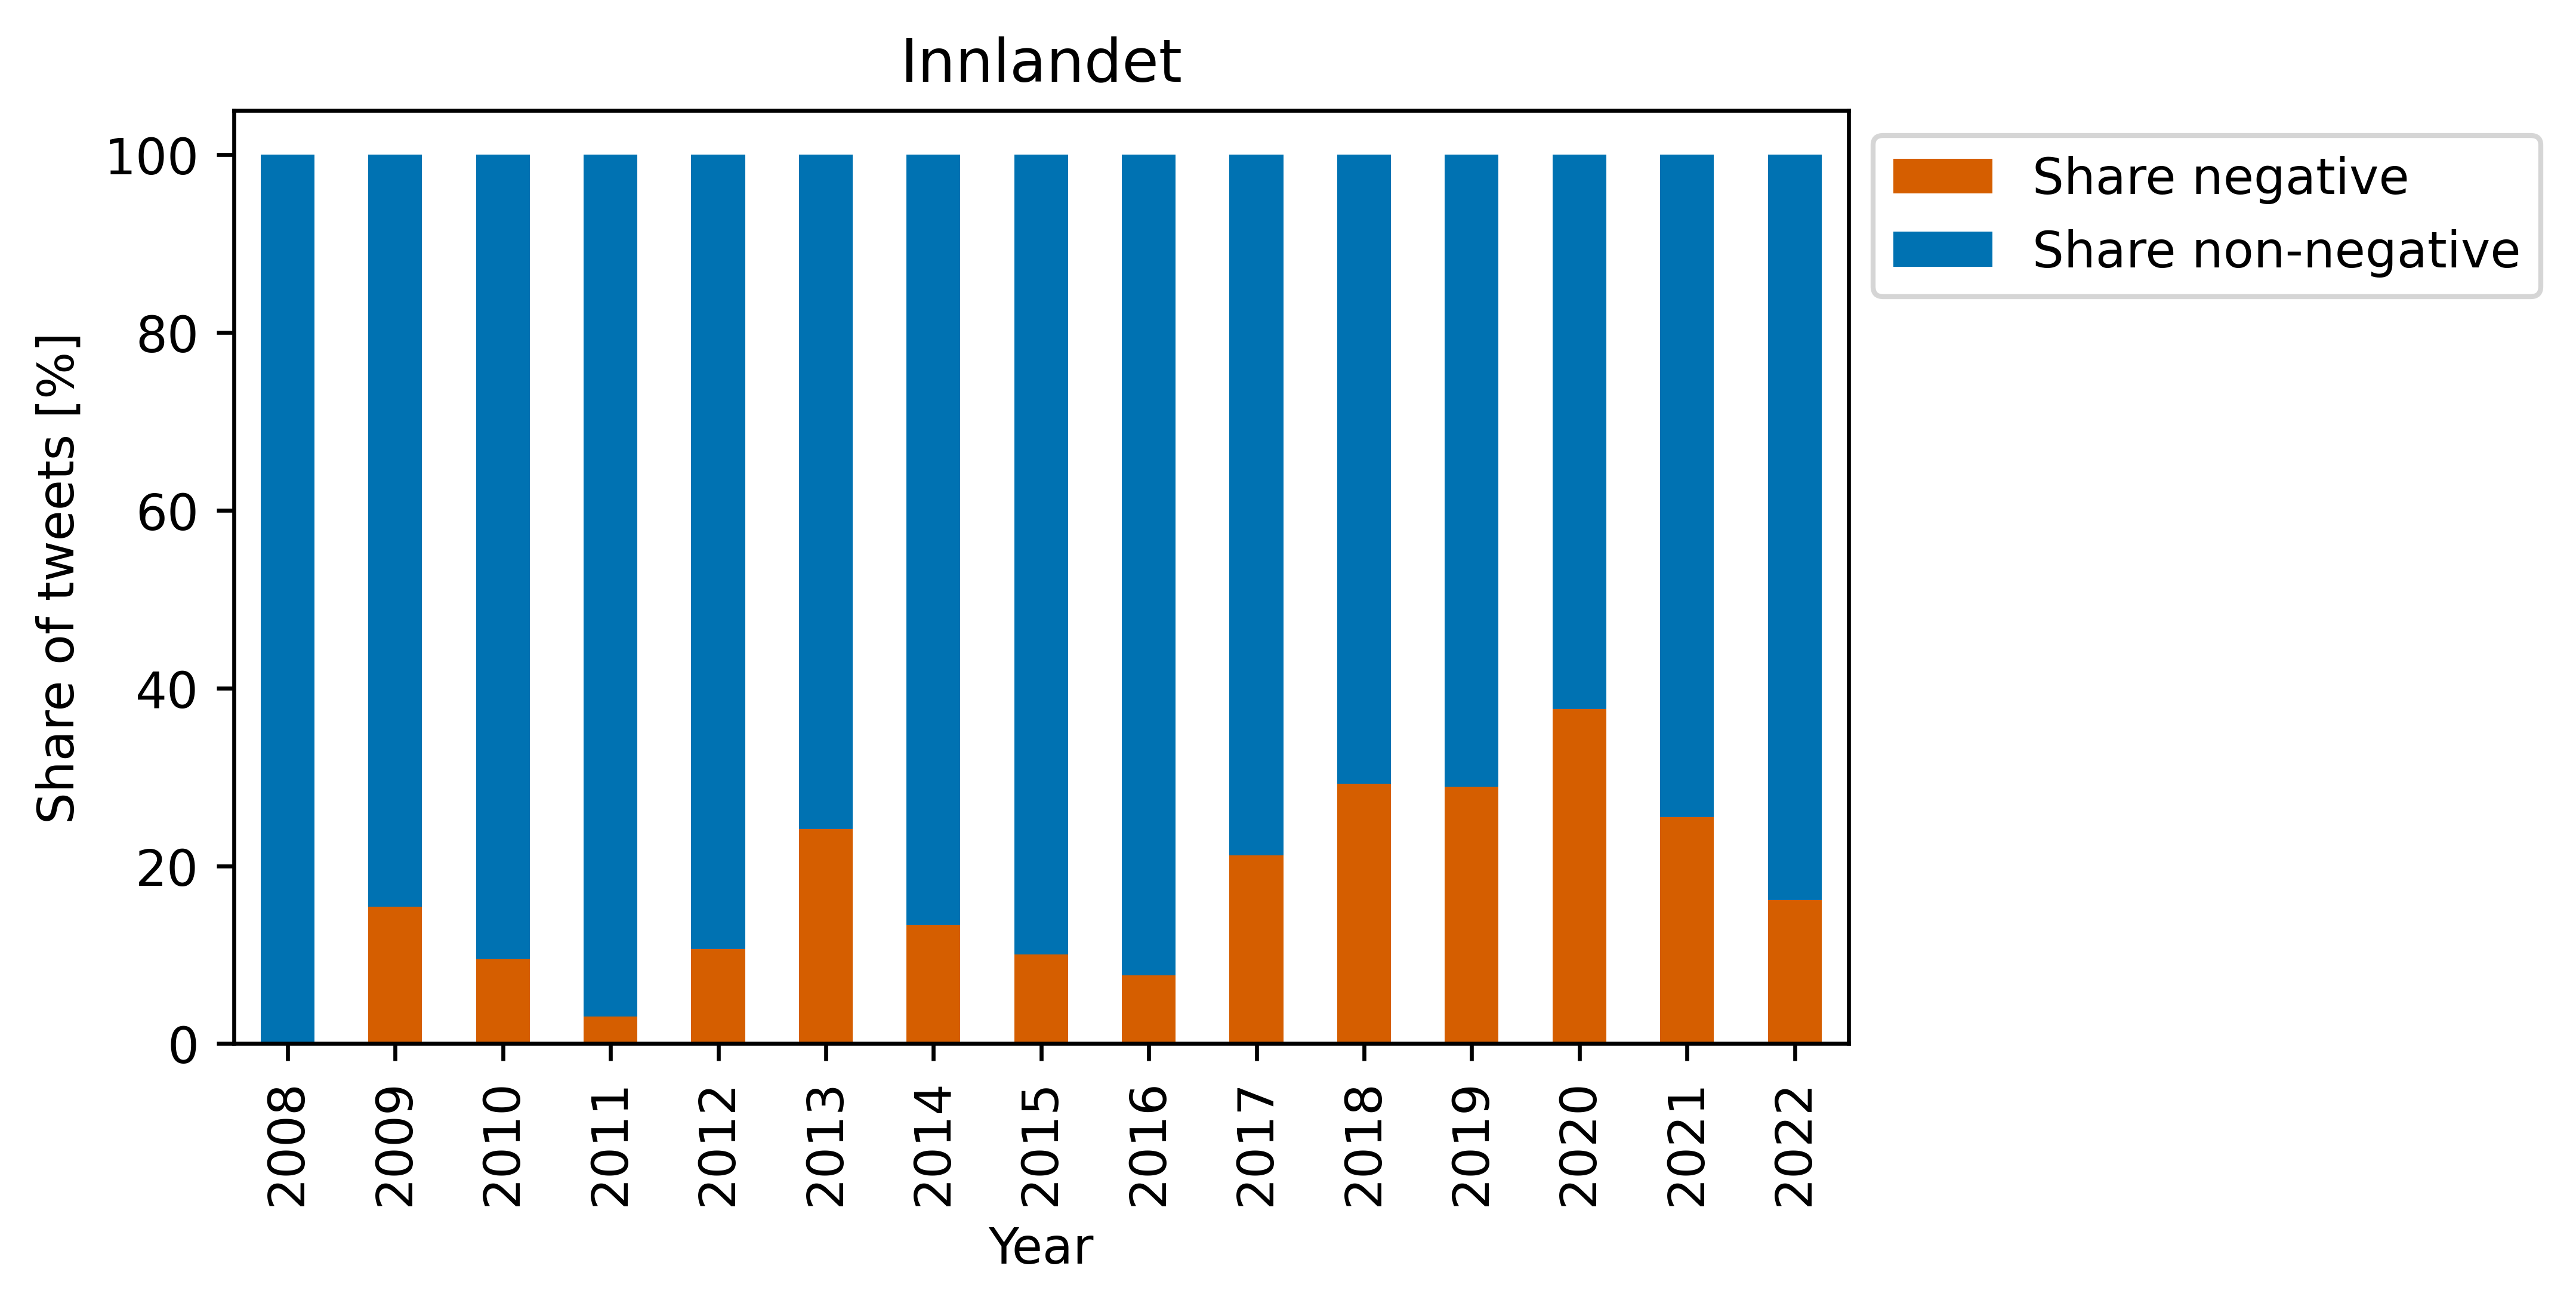

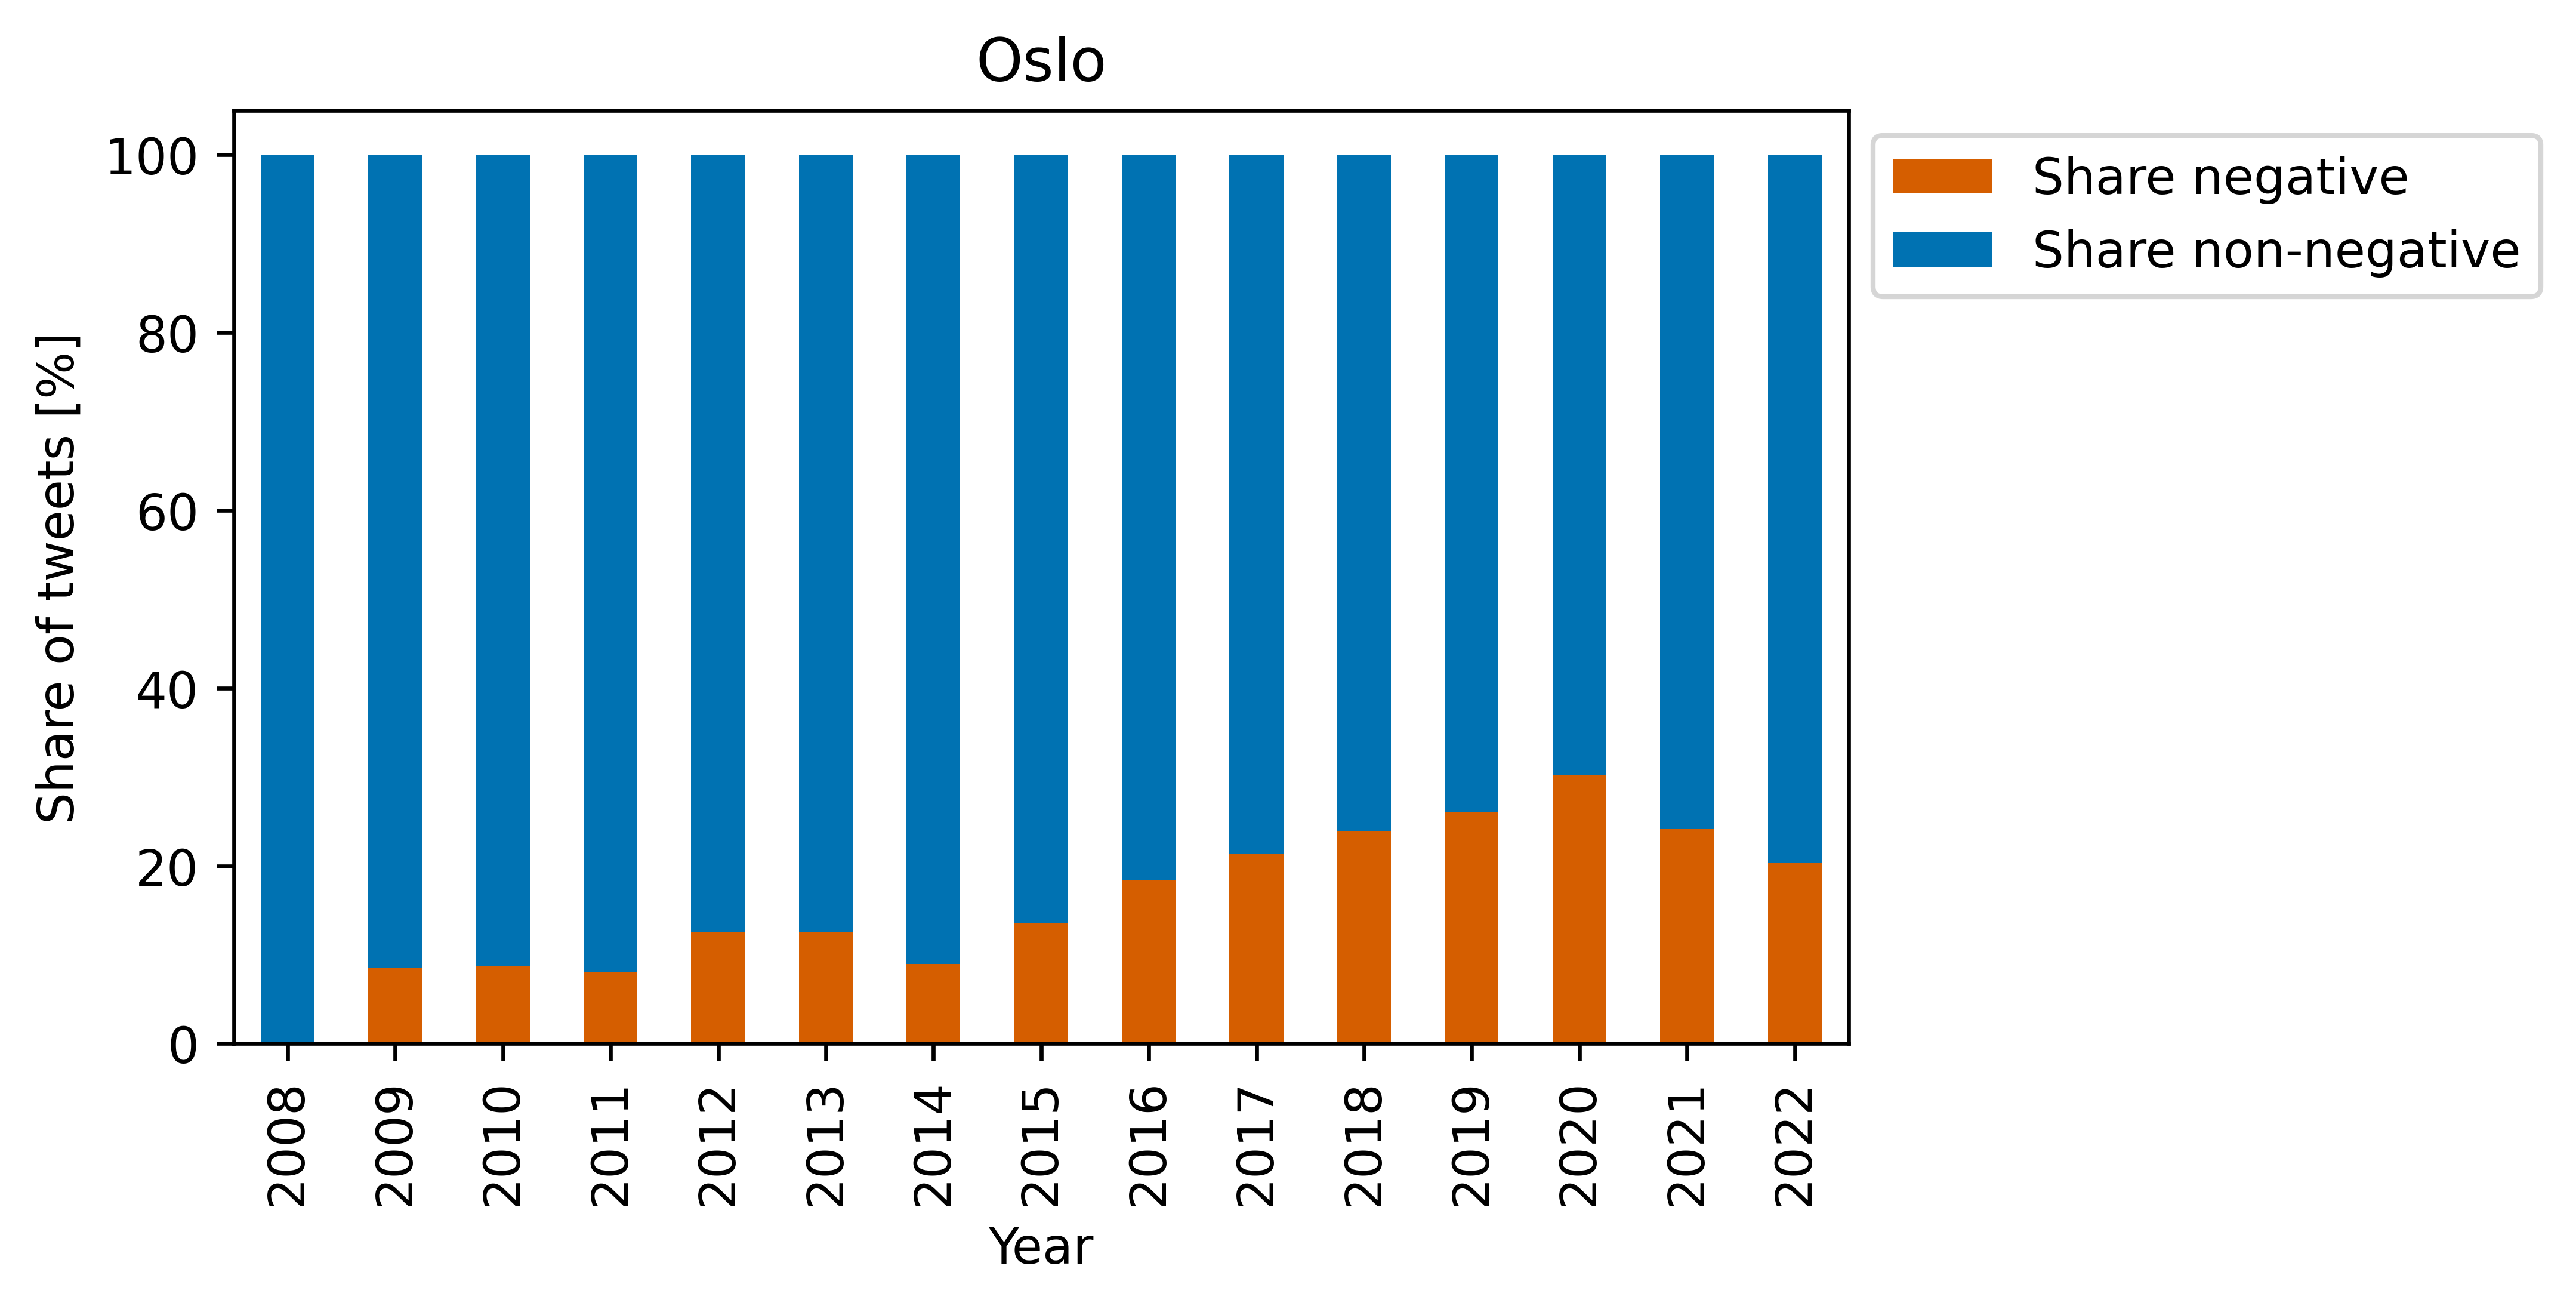

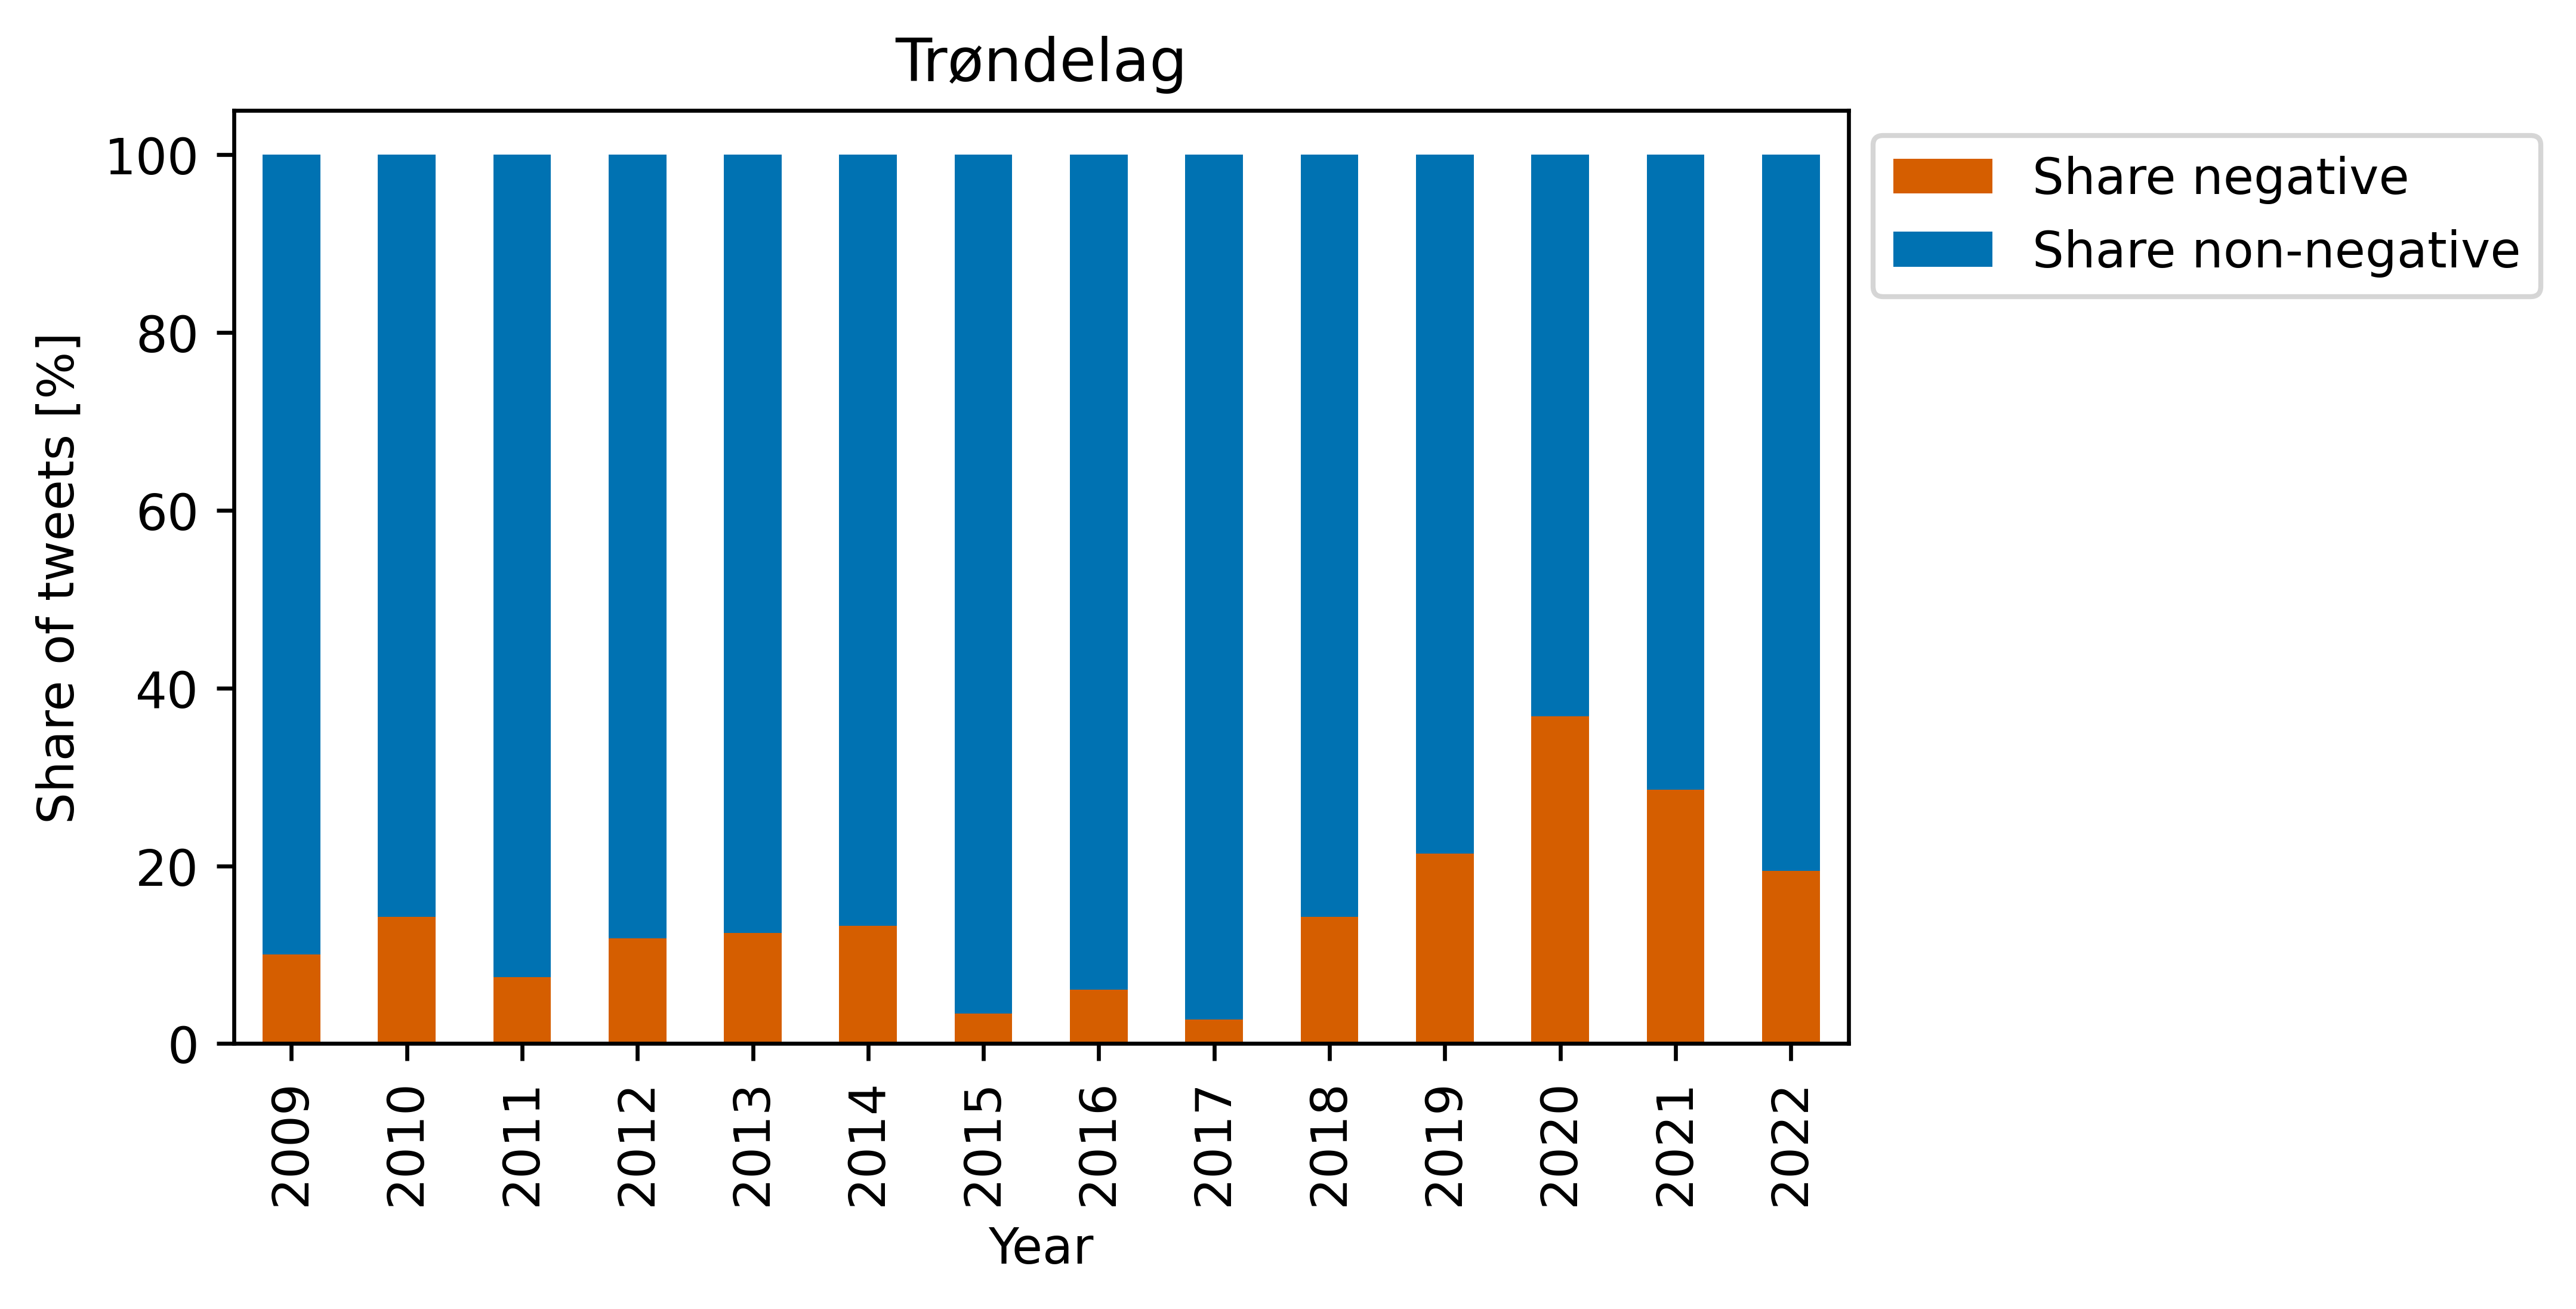

In [29]:
for county in county_list:
    fig, ax = plt.subplots(figsize=(2*3.54,3.54), dpi=600,layout="constrained")
    gdf = gdf_yearly_county.loc[gdf_yearly_county['NUTS_NAME'] == str(county)]
    gdf.groupby(
        'year'
    ).count(
    ).rename(
        columns={
            'label' : 'total_tweets'
        }
    ).assign(
        non_negative_tweets = gdf.groupby('year').sum().label,
        negative_tweets = lambda x : x.total_tweets - x.non_negative_tweets,
        share_negative = lambda x: 100*x.negative_tweets/x.total_tweets,
        share_non_negative = lambda x: 100-x.share_negative
    ).drop(
        columns={
            'geometry',
            'NUTS_NAME',
            'created_at'
        }
    ).plot.bar(
        title = county,
        y = ['share_negative','share_non_negative'],
        stacked = True,
        ax=ax,
        color = [vermilion, blue],
        label = ['Share negative','Share non-negative']
    )
    
    plt.legend(bbox_to_anchor =(1,1))
    plt.xlabel('Year')
    plt.ylabel('Share of tweets [%]')
    
    #plt.savefig('figures/temporal_bar_'+str(county.replace(" ", ""))+'.eps',bbox_inches='tight')
    plt.savefig('figures/temporal_bar_'+str(county.replace(" ", ""))+'.pdf',bbox_inches='tight')
    #plt.savefig('figures/png/temporal_bar_'+str(county.replace(" ", ""))+'.png',bbox_inches='tight', facecolor='white', edgecolor='black')
    #plt.close()
    

In [30]:
# You can run this to look at the yearly shares at a regional level.

#for county in county_list:
#    gdf = gdf_yearly_county.loc[gdf_yearly_county['NUTS_NAME'] == str(county)]
#    gdf = gdf.groupby(
#        'year'
#    ).count(
#    ).rename(
#        columns={
#            'label' : 'total_tweets'
#        }
#    ).assign(
#        non_negative_tweets = gdf.groupby('year').sum().label,
#        negative_tweets = lambda x : x.total_tweets - x.non_negative_tweets,
#        share_negative = lambda x: 100*x.negative_tweets/x.total_tweets,
#        share_positive = lambda x: 100-x.share_negative
#    ).drop(
#        columns={
#            'geometry',
#            'NUTS_NAME',
#            #'label',
#            'created_at'
#        }
#    )
#    print(county + ': ' + str(gdf))

In [31]:
gdf_monthly_results_grouped = gdf_monthly_results
gdf_monthly_results_grouped = gdf_monthly_results_grouped.groupby(
    'loc'
).first(
).assign(
    total_tweets = gdf_monthly_results.groupby('loc').count().label,
    negative_tweets = gdf_monthly_results.groupby('loc').sum().label
)


In [32]:
df_twitter_monthly.index = df_twitter_monthly[
    'created_at'
].dt.to_period(
    'M'
)

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [33]:
gdf_monthly_county_results.loc[gdf_monthly_county_results['NUTS_NAME'] == 'Trøndelag']

NUTS_NAME                   id                created_at  label  \
49914  Trøndelag           1783054071 2009-05-13 10:04:21+00:00    1.0   
49915  Trøndelag           1729488721 2009-05-07 18:17:16+00:00    1.0   
49916  Trøndelag           1360063572 2009-03-20 13:03:33+00:00    1.0   
49917  Trøndelag           1182899766 2009-02-06 11:51:50+00:00    1.0   
49918  Trøndelag           4324277061 2009-09-23 20:25:52+00:00    0.0   
...          ...                  ...                       ...    ...   
56627  Trøndelag  1581988753144709120 2022-10-17 12:41:25+00:00    0.0   
56628  Trøndelag  1581988618595622912 2022-10-17 12:40:53+00:00    0.0   
56629  Trøndelag  1581988500965978112 2022-10-17 12:40:25+00:00    0.0   
56630  Trøndelag  1581984429073141760 2022-10-17 12:24:14+00:00    1.0   
56631  Trøndelag  1581874121306095616 2022-10-17 05:05:54+00:00    0.0   

                        geometry  
49914  POINT (10.39519 63.43057)  
49915  POINT (10.19505 63.87759)  
49916  POINT (10.39519 63.43057)  
49917  POINT (10.19505 63.87759)  
49918  POINT (10.19505 63.87759)  
...                          ...  
56627  POINT (10.39519 63.43057)  
56628  POINT (10.39519 63.43057)  
56629  POINT (10.39519 63.43057)  
56630  POINT (11.85401 64.48059)  
56631  POINT (10.39519 63.43057)  

[6718 rows x 5 columns]

In [34]:
gdf_monthly_county_results.loc[gdf_monthly_county_results['NUTS_NAME'] == 'Trøndelag']

NUTS_NAME                   id                created_at  label  \
49914  Trøndelag           1783054071 2009-05-13 10:04:21+00:00    1.0   
49915  Trøndelag           1729488721 2009-05-07 18:17:16+00:00    1.0   
49916  Trøndelag           1360063572 2009-03-20 13:03:33+00:00    1.0   
49917  Trøndelag           1182899766 2009-02-06 11:51:50+00:00    1.0   
49918  Trøndelag           4324277061 2009-09-23 20:25:52+00:00    0.0   
...          ...                  ...                       ...    ...   
56627  Trøndelag  1581988753144709120 2022-10-17 12:41:25+00:00    0.0   
56628  Trøndelag  1581988618595622912 2022-10-17 12:40:53+00:00    0.0   
56629  Trøndelag  1581988500965978112 2022-10-17 12:40:25+00:00    0.0   
56630  Trøndelag  1581984429073141760 2022-10-17 12:24:14+00:00    1.0   
56631  Trøndelag  1581874121306095616 2022-10-17 05:05:54+00:00    0.0   

                        geometry  
49914  POINT (10.39519 63.43057)  
49915  POINT (10.19505 63.87759)  
49916  POINT (10.39519 63.43057)  
49917  POINT (10.19505 63.87759)  
49918  POINT (10.19505 63.87759)  
...                          ...  
56627  POINT (10.39519 63.43057)  
56628  POINT (10.39519 63.43057)  
56629  POINT (10.39519 63.43057)  
56630  POINT (11.85401 64.48059)  
56631  POINT (10.39519 63.43057)  

[6718 rows x 5 columns]

Testing

In [49]:
exclude_list = ['Møre og Romsdal']
gdf_monthly_county_results.loc[~gdf_monthly_county_results.NUTS_NAME.isin(exclude_list)]

NUTS_NAME                   id                created_at  label  \
873    Nordland           1045067708 2008-12-08 14:12:10+00:00    0.0   
874    Nordland           1694459285 2009-05-04 09:43:32+00:00    1.0   
875    Nordland           1604267388 2009-04-24 14:55:40+00:00    1.0   
876    Nordland           1257446018 2009-02-27 09:14:13+00:00    1.0   
877    Nordland           2418973823 2009-07-01 11:57:22+00:00    0.0   
...         ...                  ...                       ...    ...   
63800     Viken  1582315632577896449 2022-10-18 10:20:19+00:00    0.0   
63801     Viken  1582308145551925250 2022-10-18 09:50:34+00:00    1.0   
63802     Viken  1582133975992086529 2022-10-17 22:18:29+00:00    1.0   
63803     Viken  1582091278925242370 2022-10-17 19:28:49+00:00    1.0   
63804     Viken  1581799155575316480 2022-10-17 00:08:01+00:00    NaN   

                        geometry  
873    POINT (14.66639 68.33306)  
874    POINT (14.38175 67.28443)  
875    POINT (14.38175 67.28443)  
876    POINT (14.38175 67.28443)  
877    POINT (14.38175 67.28443)  
...                          ...  
63800  POINT (10.17564 59.69649)  
63801  POINT (10.17564 59.69649)  
63802  POINT (11.04515 59.95341)  
63803  POINT (10.17564 59.69649)  
63804  POINT (10.81286 59.76698)  

[62932 rows x 5 columns]

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


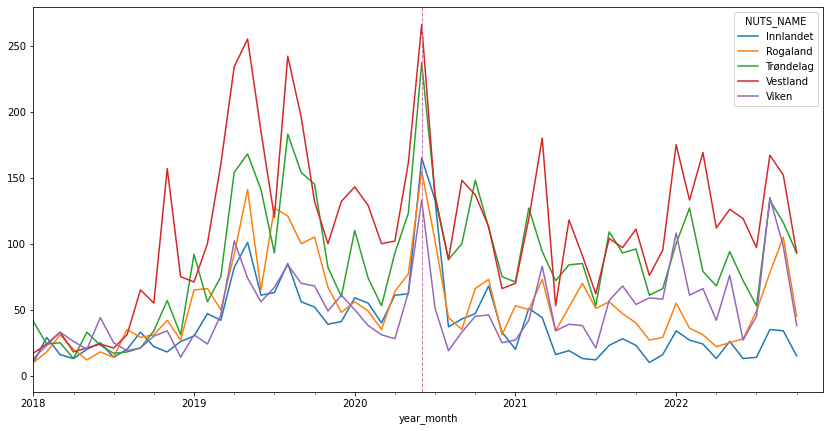

In [61]:
fig, ax = plt.subplots(figsize = (4*3.54,2*3.54))

exclude_list = ['Oslo','Agder','Nordland','Vestfold og Telemark','Troms og Finnmark', 'Møre og Romsdal']
gdf_test = gdf_monthly_county_results.loc[~gdf_monthly_county_results.NUTS_NAME.isin(exclude_list)]

gdf_test.assign(
    year_month = lambda x : x.created_at.dt.to_period('M')
).sort_values(
    'year_month'
).drop(
    columns={
        'created_at',
        'geometry',
        'id'
    }
).groupby(
    [
        'year_month',
        'NUTS_NAME'
    ]
).count(
).unstack(
).plot.line(
    y = 'label',
    ax=ax,
    #logx = True
    
)

ax.set_xlim([dt.date(2018, 1, 1), dt.date(2022, 12, 12)])

ax.axvline(
    dt.datetime(2020, 6, 1),
    color="#CC79A7",
    label='Meld. St. 28 (2019-2020) - Tighter rules for wind power introduced',
    linestyle = "--",
    linewidth=1
)

#plt.ion = True